In [1]:
import os
import sys
sys.path.append('/home/kevinteng/Desktop/DE_Project')
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from coord_conv import CoordConv
import cv2
import utils
import utils_vis
import utils_model
from sklearn.model_selection import train_test_split
from utils_vis import plot_comparison

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---------------------

# Retrieving and Preprocess Data

Image size:  100


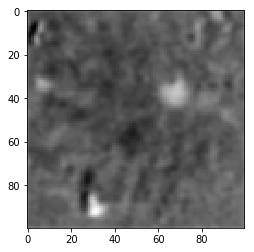

In [2]:
dataset = np.load('/home/kevinteng/Desktop//jpg_to_npy_benchmark/DG13_3-8-17_preprocessed_dF.npy')
NEW_SIZE = 100
#re_list = dataset
re_list = utils.resize(dataset, NEW_SIZE)
IMG_SIZE = re_list.shape[1]

print('Image size: ', IMG_SIZE)
#Dimension for network should include the color channel 
re_list = np.expand_dims(re_list, axis = -1)
#Cast data type to float32 for TensorFlow
# re_list = re_list.astype('float32')
re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)

for img in re_list:
    plt.imshow(np.reshape(img, (IMG_SIZE, IMG_SIZE)), cmap = 'gray')
    plt.show()
    
    break
    
#     if input()=='exit':
#         break

In [3]:
#apply min max norm for mean image
re_list = utils.min_max_norm(re_list)
#max_img_ori = np.expand_dims(max_img_ori, -1)
print('Max value:', np.max(re_list))
print('Min value:', np.min(re_list))


Max value: 1.0
Min value: 0.0


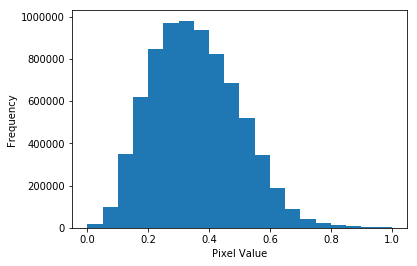

In [4]:
#plot historgram for min max norm image
plt.hist(tf.reshape(re_list, [-1]),20,[0,1])
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

----------------------------------------------------------


# Helper Function

In [5]:
def create_ran_numbers(img_size):
    '''
    Function to create random coordinates 
    
    @param img_size: Image size 
    
    return:
    random generated x,y coordinates 
    '''
    c1=np.random.randint(img_size, size=1)
    c2=np.random.randint(img_size, size=1)
    c1=tf.convert_to_tensor( c1,dtype=None,dtype_hint=None,name=None)
    c2=tf.convert_to_tensor( c2,dtype=None,dtype_hint=None,name=None)
    return c1,c2

@tf.function
def create_tf_tilecords(coord_list, img_size):
    o1,o2=coord_list
    multiply=tf.constant([img_size*img_size])
    y1=tf.reshape(tf.tile(o1,multiply),[img_size,img_size,1])
    y2=tf.reshape(tf.tile(o2,multiply),[img_size,img_size,1])

    y=tf.concat((y1,y2),axis=2)

    return tf.dtypes.cast(y, tf.float32),tf.dtypes.cast(coord_list, tf.float32)

@tf.function
def tf_create_onehotcords(dat):
    o1,o2=dat
    y1=tf.one_hot(o1,100)
    y2=tf.one_hot(o2,100)
    y2=tf.transpose(y2)
    y=tf.math.multiply(y1,y2)
    #y=tf.transpose(y)
    return y

def create_dat_samples(n):
    '''
    Function to create stacks of coordinates, tiled coordinates, one hot images
    @param n: number of neurons
    '''
    ta = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    tb = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    coords = tf.TensorArray(tf.float32, size=0, dynamic_size = True)
    for _ in tf.range(n):
        dat=create_ran_numbers(img_size=100)
        b1,b2=create_tf_tilecords(dat, 100)
        c1=tf_create_onehotcords(dat)
        c1=tf.expand_dims(c1, axis=2, name=None)
        
        #tile coordinates
        ta = ta.write(_, b1/99)  #(n, img_size, img_size, 1)
        #one hot images
        tb = tb.write(_, c1) #(n, img_size, img_size, 1)
        #coordinates
        coords = coords.write(_, dat) #(n, 2, 1)
    return coords.stack(), ta.stack(),tb.stack()

def neuron_like_image(n_neurons):
    '''
    Function to paint neuron-like images
     @param n_neurons: number of neurons
    '''
    _,_,one_hot_imgs = create_dat_samples(n_neurons)
    stack_imgs = tf.reduce_sum(one_hot_imgs, axis = 0)
    return tf.expand_dims(stack_imgs, axis = 0) #(1, img_size, img_size, 1)

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

---

# Validation

In [6]:
n_neurons = 20
img_size = 100
coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
coords = tf.reshape(coords, [n_neurons, 1,1,2])
tf.print(tf.shape(coords))

[20 1 1 2]


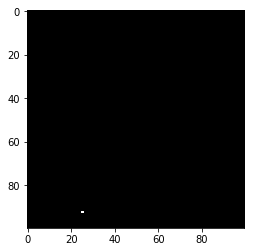

In [7]:
plt.imshow(tf.squeeze(ori_one_hot_imgs[0]), cmap = 'gray')

-----------------------------------

# Model

In [8]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from tensorflow.keras.layers import Input, Softmax
from tensorflow.keras.regularizers import l1
from utils_model import conv_block, coordconv_block, up_block, up_coord_block
from tensorflow.keras import layers

def encoder(inps, img_size):
    #1st block
    coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 32, kernel_size = 3, padding='same')(inps)
    leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
    coord02 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky01)
    leaky02 = tf.keras.layers.LeakyReLU(0.5)(coord02)
    add01 = tf.keras.layers.Add()([leaky02, inps])
    
    #2nd block
    coord03 =  CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                      filters = 128, kernel_size = 3, padding='same')(add01)
    leaky03 = tf.keras.layers.LeakyReLU(0.5)(coord03)
    coord04 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky03)
    leaky04 = tf.keras.layers.LeakyReLU(0.5)(coord04)
    add02 = tf.keras.layers.Add()([leaky04, add01])
    
    #3rd block
    coord05 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 256, kernel_size = 3, padding='same')(add02)
    leaky05 = tf.keras.layers.LeakyReLU(0.5)(coord05)
    coord06 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                        filters = 1, kernel_size = 3, padding='same')(leaky05)
    leaky06 = tf.keras.layers.LeakyReLU(0.5)(coord06)
    add03 = tf.keras.layers.Add()([leaky06, add02])

    #4th block
    coord07 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 128, kernel_size = 3, padding='same')(add03)
    leaky07 = tf.keras.layers.LeakyReLU(0.5)(coord07)
    coord08 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky07)
    leaky08 = tf.keras.layers.LeakyReLU(0.5)(coord08)
    add04 =tf.keras.layers.Add()([leaky08, add03])
    
    #5th block
    coord09 =CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                       filters = 64, kernel_size = 3, padding='same')(add04)
    leaky09 = tf.keras.layers.LeakyReLU(0.5)(coord09)
    coord10=CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky09)
    leaky10 = tf.keras.layers.LeakyReLU(0.5)(coord10)
    add05 = tf.keras.layers.Add()([leaky10, add04])
    
    #6th block
    coord11 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                    filters = 32, kernel_size = 3, padding='same')(add05)
    leaky11 = tf.keras.layers.LeakyReLU(0.5)(coord11)
    coord12 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
                 filters = 1, kernel_size = 3, padding='same')(leaky11)
    leaky12 = tf.keras.layers.LeakyReLU(0.5)(coord12)
    add06 = tf.keras.layers.Add()([leaky12, coord11])
    output = Conv2D(1, kernel_size = 3,activation = 'sigmoid', padding='same')(add06)
    
    return output


def de_conv(input_tensor):
    coord01 = CoordConv(x_dim = 100, y_dim = 100, with_r = False, filters = 100,
              kernel_size = 1, padding='same', activation='relu')(input_tensor)
    conv01 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(coord01)
    conv02 = Conv2D(filters = 50, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv01)
    conv03 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv02)
    conv04 = Conv2D(filters = 100, kernel_size = 1, strides = 1, padding = "same", activation = 'relu')(conv03)
    conv05 = Conv2D(filters = 1, kernel_size = 1, strides = 1, padding = "same" )(conv04)
    f1 = Flatten()(conv05)
    output = Softmax(axis = -1)(f1)

    return output

def latent_space(encoded_imgs, deconv_imgs, coords, batch_size):
    '''
    This function construct the dot product of the output of an encoder(batch_size, img_size, img_size, 1) 
    with the one hot images generated by decoord-conv(n_neurons, img_size, img_size, 1), which yields
    similarity score (batch_size, n_neurons). Similarity score is then concatenate to the last layer of the 
    input coordinates with the corresponding batch (batch_size, n_neurons, 3)
    
    @encoded_imgs: output images from the encoder
    @deconv_imgs: one hot images generated from the coordinate list 
    @coords: A list of coordinates generated randomly based on the number of neurons
    @batch_size: Batch size of the input image for encoder, to allocate size for writing in loop
    
    return: 
        latent space with dim (batch_size, n_neurons, 3, 1)
    '''
    similarity_score = tf.tensordot(encoded_imgs, deconv_imgs, [[1,2,3],[1,2,3]]) #(batch_size, n_neurons)
    squeeze_coords = tf.squeeze(coords/(img_size-1)) #coords dim (n_neurons, 1, 1, 2) = > (n_neurons, 2)
    latent = tf.TensorArray(tf.float32, size=0, dynamic_size=True)
    for i in tf.range(batch_size):
        concat = tf.stack((squeeze_coords[:,-2], squeeze_coords[:,-1], similarity_score[i]), axis=-1)    
        latent = latent.write(i, concat) #(batch_size, n_neurons, 3)
    return tf.expand_dims(latent.stack(), axis = -1), similarity_score

def decoder(latent_dim, img_size):
    flat_01 = Flatten()(latent_dim)
    dense_01 = Dense(25*25*32, activation = 'relu')(flat_01)
    dense_01 = Reshape((25,25,32))(dense_01)
    up_01 = up_block(dense_01, up_size = 2, filters = 32, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    up_02 = up_block(up_01, up_size = 2, filters = 64, kernel_size = 3,
                            strides = 1, padding = 'same', activation = 'relu')
    output = coordconv_block(up_02, x_dim = img_size, y_dim = img_size, 
                              filters = 1, kernel_size = 3, strides = 1,
                              padding = 'same', activation = None)
    return output

class learnable_coords(layers.Layer):
    def __init__(self, coords):
        super(learnable_coords, self).__init__()
        self.learned_coords = tf.Variable((coords), trainable = True)

    def __call__(self, img_size):
        y = self.learned_coords/(img_size-1) #normalize the coordinates
    #         y = tf.clip_by_value(y, clip_value_min=0, clip_value_max=1) #clip values
        return y
    
def dataset_parse(dataset_path, NEW_SIZE):
    dataset = np.load(dataset_path)
    #re_list = dataset
    re_list = utils.resize(dataset, NEW_SIZE)
    #Dimension for network should include the color channel 
    re_list = np.expand_dims(re_list, axis = -1)
    #Cast data type to float32 for TensorFlow
    # re_list = re_list.astype('float32')
    re_list = tf.convert_to_tensor(re_list, dtype = tf.float32)
    
    return re_list

def stack4plot(one_hot_imgs):
    '''
    Functions to sum all one hot images along axis=0 for easy plot
    '''
    return tf.squeeze(tf.reduce_sum(one_hot_imgs, axis = 0))

In [9]:
# def encoder02(inps, img_size):
#     #1st block
#     coord01 = CoordConv(x_dim = img_size, y_dim = img_size, with_r = False, 
#                         filters = 256, kernel_size = 3, padding='same')(inps)
#     leaky01 =tf.keras.layers.LeakyReLU(0.5)(coord01)
#     conv01 = Conv2D(filters = 128, kernel_size = 3, strides = 1, padding = "same", activation = 'relu')(leaky01 )
#     leaky02 = tf.keras.layers.LeakyReLU(0.5)(conv01)
#     output = Conv2D(1, kernel_size = 3,activation = 'linear', padding='same')(leaky02 )
#     return output

-----------------------------------------------------------------

## Build Model

In [10]:
#build encoder 
inps = Input(shape=(img_size, img_size, 1))
encoder_model = Model(inps, encoder(inps, img_size))

#build coord model
inp = Input(shape=(100, 100,2)) #(batch_size, img_size, img_size, 2)
de_coordconv = Model(inp, de_conv(inp))
de_coordconv.load_weights("best_class_model100_02.hdf5")

#decoder
latent_dim = Input(shape=(n_neurons, 3, 1))
decoder_model = Model(latent_dim, decoder(latent_dim, img_size))

#learnable coords
l_coords = learnable_coords(coords)

In [11]:
# encoder_model.summary()

## Train Model

--------------------------------------

In [12]:
lr=0.001
opt = tf.keras.optimizers.Adam(lr)
loss_fn = tf.losses.MeanSquaredError()

@tf.function
def train_fn(inp_imgs, coords, img_size, batch_size):
    with tf.GradientTape() as tape:
        #custom layer for updating coordinates
        updated_coords = l_coords(img_size)
        m1 = tf.constant([1,img_size,img_size,1], tf.int32) #multiplier for tiling 
        #tile coordinates
        tile_cd = tf.tile(updated_coords, m1)
        #de-coordconv model
        de_coordconv.trainable = False #freeze de-coordconv
        one_hot_imgs = tf.reshape(de_coordconv(tile_cd),[-1,img_size, img_size, 1]) #(n_neurons, img_size, img_size, 1)
        #output from encoder 
        encoder_output = encoder_model(inp_imgs)
        #latent space
        latent, similarity_score = latent_space(encoder_output, one_hot_imgs, coords, batch_size)#(batch_size, n_neurons, 3, 1)
        #reconstruction 
        reconstruction = decoder_model(latent)
        loss = loss_fn(inp_imgs, reconstruction)
        
    varis = encoder_model.trainable_variables + decoder_model.trainable_variables + l_coords.trainable_variables
    grad_model = tape.gradient(loss, varis)
#     grad_coords = tape.gradient(loss, l_coords.trainable_variables)
    opt.apply_gradients(zip(grad_model, varis))
#     opt.apply_gradients(zip(grad_coords, l_coords.trainable_variables))
    
    return loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model 

In [13]:
# ds_dir = '/home/kevinteng/Desktop/jpg_to_npy_benchmark/'

# for d in sorted(os.listdir(ds_dir)):
#     merge_d = os.path.join(ds_dir+d)
#     imgs = dataset_parse(merge_d, 100)
#     break

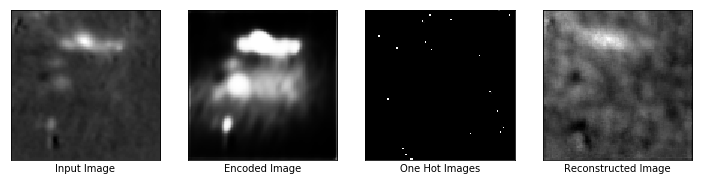

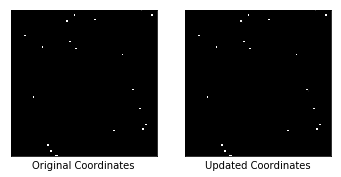

Epochs: 10, Loss: 0.003533207345753908
Similarity scores: [3.8838897e-02 6.9024153e-03 9.8815948e-01 3.6267576e-01 1.2476973e-01
 4.5574140e-03 1.4083134e-02 7.6353189e-04 1.4954844e-03 8.1724040e-03
 4.5626674e-02 6.3043579e-02 1.8991321e-02 1.4733191e-02 4.3892618e-03
 1.8312773e-01 6.4045608e-02 2.8634051e-02 9.4846731e-01 4.7875694e-03]
Updated Coordinates: [[[0.25143757 0.9295012 ]]]
Gradient min:-0.0006111027905717492, max:0.0004411033005453646



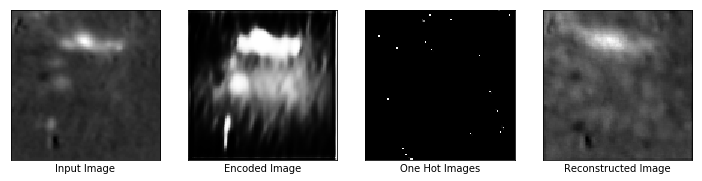

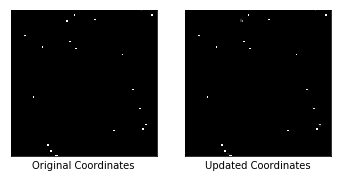

Epochs: 20, Loss: 0.0036460685078054667
Similarity scores: [2.76068032e-01 2.04555765e-02 9.82816696e-01 1.49752602e-01
 3.61379206e-01 1.28525160e-02 2.78653530e-03 4.21612000e-04
 4.48783394e-03 2.50423085e-02 2.27244467e-01 1.15860933e-02
 2.61534601e-02 1.82909984e-02 3.15259919e-02 4.19534892e-01
 1.22885145e-02 2.33326256e-02 9.11731064e-01 2.57936772e-03]
Updated Coordinates: [[[0.25150403 0.92950785]]]
Gradient min:-0.003520888276398182, max:0.0027399456594139338



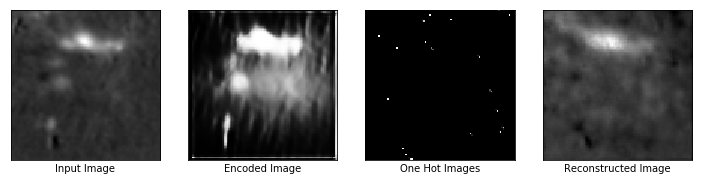

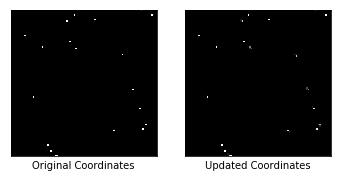

Epochs: 30, Loss: 0.0034953514114022255
Similarity scores: [0.1966392  0.0570859  0.98191977 0.07967744 0.43508714 0.03395531
 0.00502479 0.00229762 0.02129303 0.06259101 0.27232516 0.0528727
 0.05547062 0.02774261 0.05687774 0.43918288 0.02603947 0.03422126
 0.84412575 0.00744196]
Updated Coordinates: [[[0.25146186 0.9294989 ]]]
Gradient min:-0.0029785980004817247, max:0.002329518785700202



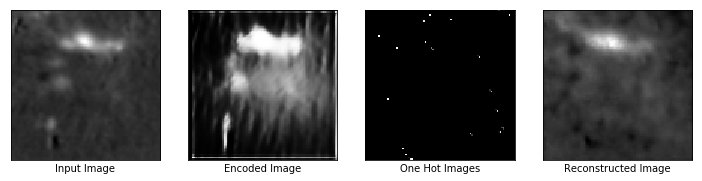

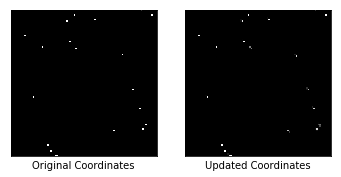

Epochs: 40, Loss: 0.0033022109419107437
Similarity scores: [0.2945931  0.10964824 0.9338785  0.0658587  0.42346418 0.04112167
 0.0087665  0.01096436 0.02438919 0.11673532 0.33345762 0.07763451
 0.09753102 0.02819108 0.07655074 0.47941998 0.03451186 0.04203841
 0.8215106  0.00692351]
Updated Coordinates: [[[0.25144857 0.92948383]]]
Gradient min:-0.0030224521178752184, max:0.0010685480665415525



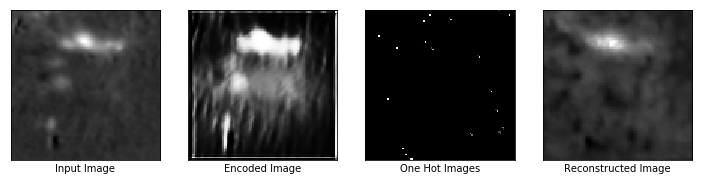

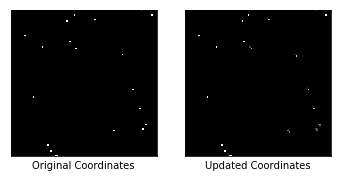

Epochs: 50, Loss: 0.0038786709774285555
Similarity scores: [0.5391789  0.03988994 0.93131465 0.17342642 0.21246025 0.03160655
 0.01198565 0.00179212 0.01188514 0.03863586 0.15087678 0.08270299
 0.06199475 0.05329309 0.04104094 0.27271786 0.03076458 0.00957279
 0.8785549  0.03272485]
Updated Coordinates: [[[0.25163543 0.9293144 ]]]
Gradient min:-0.004372440278530121, max:0.001647101016715169



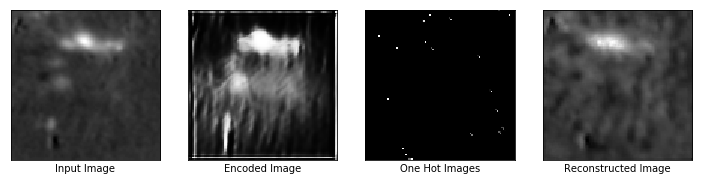

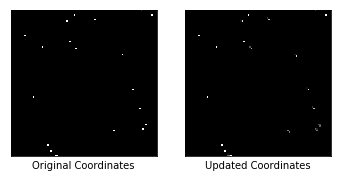

Epochs: 60, Loss: 0.002732627559453249
Similarity scores: [0.806423   0.04274631 0.8656424  0.21038558 0.18949823 0.02058664
 0.0489505  0.0021051  0.0069898  0.03942021 0.13486207 0.07399251
 0.06793173 0.03905892 0.01703969 0.20937636 0.04681343 0.003153
 0.78947914 0.01694493]
Updated Coordinates: [[[0.25198907 0.9289554 ]]]
Gradient min:-0.0010548223508521914, max:9.242373198503628e-05



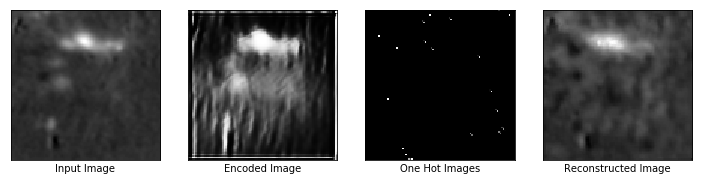

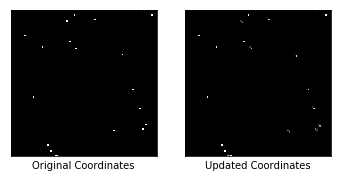

Epochs: 70, Loss: 0.002667449414730072
Similarity scores: [0.7111051  0.05810466 0.8223364  0.19306065 0.18844353 0.03730394
 0.04543891 0.00349163 0.01346093 0.05501214 0.16917066 0.05764209
 0.08724445 0.06106658 0.01690702 0.19408335 0.04371769 0.00481829
 0.7676323  0.02715432]
Updated Coordinates: [[[0.252233   0.92871994]]]
Gradient min:-0.0008019327069632709, max:4.075743709108792e-05



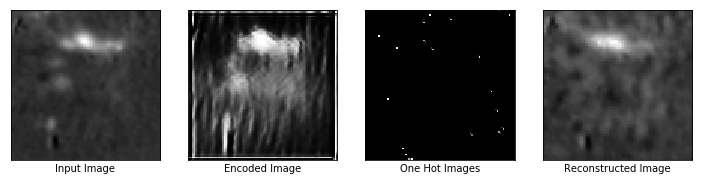

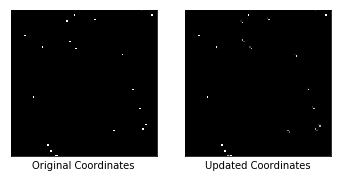

Epochs: 80, Loss: 0.0026329264510422945
Similarity scores: [0.72190475 0.06507001 0.71990544 0.14929613 0.23416075 0.03830438
 0.04660391 0.00581704 0.02116278 0.06967139 0.19724064 0.05902756
 0.09307053 0.05038032 0.01977394 0.22440383 0.04400165 0.0104416
 0.7299061  0.01749962]
Updated Coordinates: [[[0.25224042 0.9285512 ]]]
Gradient min:-0.0006980893667787313, max:9.661987132858485e-05



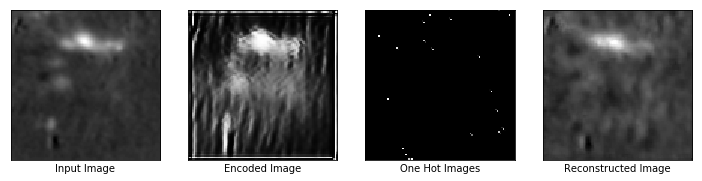

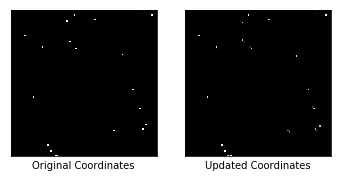

Epochs: 90, Loss: 0.0026237694546580315
Similarity scores: [0.78926945 0.06452176 0.7374578  0.14406154 0.22700036 0.06646788
 0.04482175 0.01100044 0.02897196 0.07170807 0.19898878 0.04681966
 0.0869458  0.07158553 0.02400535 0.217369   0.03683694 0.01572464
 0.7414973  0.0178964 ]
Updated Coordinates: [[[0.25212148 0.9282915 ]]]
Gradient min:-0.0008146415348164737, max:7.386848301393911e-05



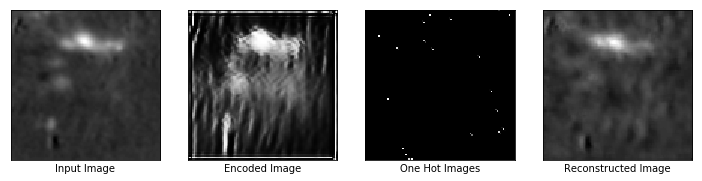

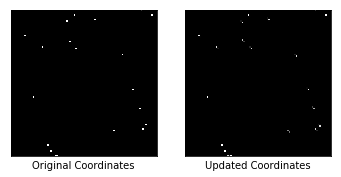

Epochs: 100, Loss: 0.0027514782268553972
Similarity scores: [0.81426066 0.05337012 0.7605706  0.11735389 0.19559205 0.03534227
 0.0445714  0.00986711 0.02520089 0.06133332 0.17289937 0.03870698
 0.06392404 0.0430618  0.01804804 0.21789092 0.03484356 0.01574931
 0.78905123 0.00764872]
Updated Coordinates: [[[0.25188136 0.9282655 ]]]
Gradient min:-0.0018669702112674713, max:9.775703802006319e-05



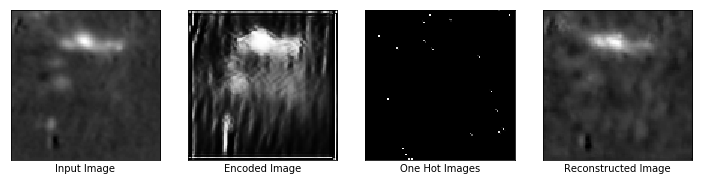

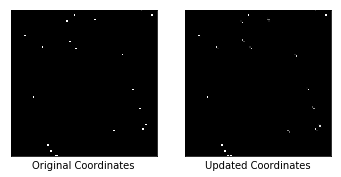

Epochs: 110, Loss: 0.0028061210177838802
Similarity scores: [0.7685802  0.04411253 0.8574556  0.07912444 0.20625511 0.06057128
 0.02093353 0.01953239 0.05036162 0.05264563 0.16793668 0.01865813
 0.04621838 0.06428432 0.04519966 0.2640208  0.01764339 0.02541329
 0.8125731  0.0106441 ]
Updated Coordinates: [[[0.25141883 0.92823666]]]
Gradient min:-0.001990125747397542, max:0.0013989419676363468



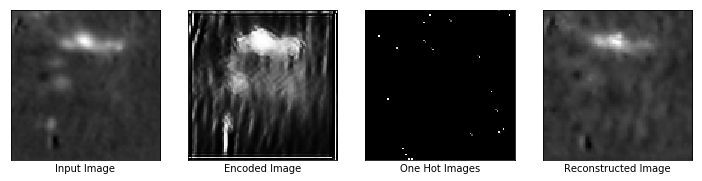

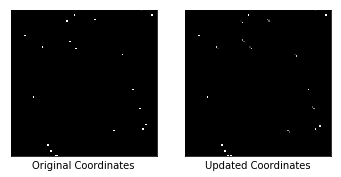

Epochs: 120, Loss: 0.0024519057478755713
Similarity scores: [0.882236   0.0470923  0.8150249  0.0734999  0.22753435 0.07006828
 0.04680747 0.01743172 0.05277844 0.05576188 0.16837561 0.01410182
 0.04773785 0.0740206  0.04367176 0.264319   0.01888319 0.05556428
 0.8041395  0.00903864]
Updated Coordinates: [[[0.25085965 0.92869747]]]
Gradient min:-0.0008081820560619235, max:0.0004917777259834111



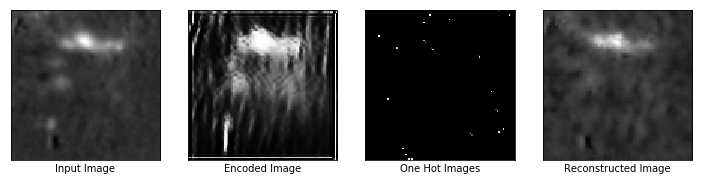

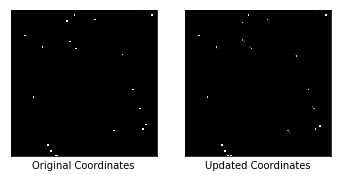

Epochs: 130, Loss: 0.0022856094874441624
Similarity scores: [0.80086976 0.04550918 0.86601824 0.0418386  0.22193259 0.07395472
 0.01383501 0.00716826 0.04096298 0.0535249  0.17520805 0.01350684
 0.04385906 0.06644969 0.0435694  0.2773901  0.01156126 0.04188744
 0.8141565  0.00872176]
Updated Coordinates: [[[0.25157845 0.92796487]]]
Gradient min:-0.0003802274586632848, max:0.00037034432170912623



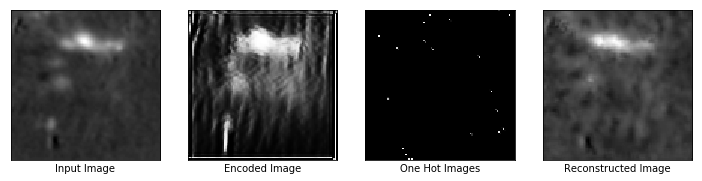

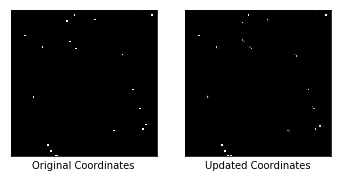

Epochs: 140, Loss: 0.0024225395172834396
Similarity scores: [0.79630643 0.03992477 0.85913783 0.07245974 0.24986933 0.10998159
 0.01286957 0.0368677  0.09414365 0.05144272 0.15689065 0.00926406
 0.04186079 0.08862071 0.0703316  0.3167782  0.00566878 0.07935818
 0.81997085 0.01744843]
Updated Coordinates: [[[0.25153387 0.92820823]]]
Gradient min:-6.728147127432749e-05, max:0.00025425502099096775



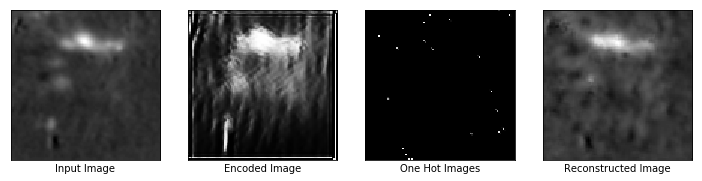

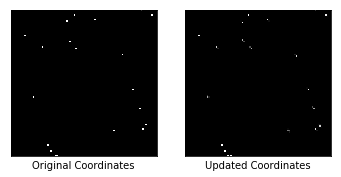

Epochs: 150, Loss: 0.002411523135378957
Similarity scores: [0.68802714 0.0328544  0.8702716  0.05969735 0.21867593 0.12180541
 0.01059576 0.04957547 0.1105245  0.04142942 0.12418962 0.00724615
 0.0343629  0.09758135 0.09162247 0.36746684 0.0054185  0.20617737
 0.78988206 0.02316903]
Updated Coordinates: [[[0.25166574 0.9280609 ]]]
Gradient min:-0.0008045447757467628, max:0.0009788258466869593



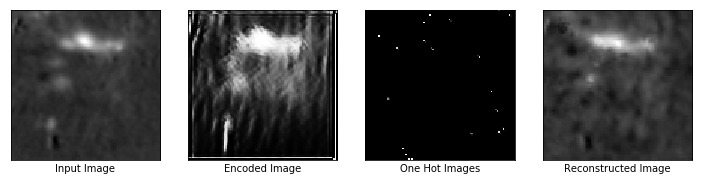

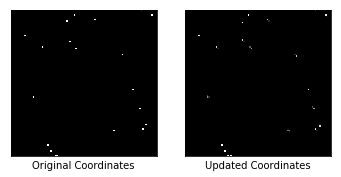

Epochs: 160, Loss: 0.002610829658806324
Similarity scores: [0.6421384  0.02552413 0.92776495 0.07537086 0.20529051 0.12603307
 0.00758148 0.05890646 0.10533598 0.03508866 0.13275221 0.00736487
 0.02819625 0.10416961 0.10889537 0.35907155 0.00616193 0.13454974
 0.7900209  0.02250677]
Updated Coordinates: [[[0.25162876 0.9281656 ]]]
Gradient min:-0.0014841837109997869, max:0.001471094787120819



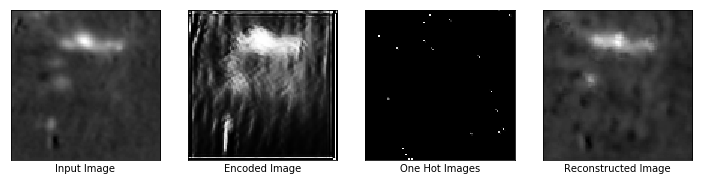

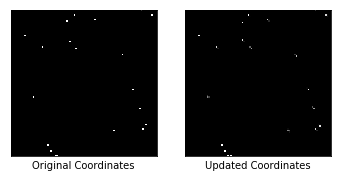

Epochs: 170, Loss: 0.0026922107208520174
Similarity scores: [0.71040547 0.02592711 0.92277884 0.07978093 0.18153341 0.13067628
 0.01288309 0.03414225 0.1085193  0.03356226 0.10952833 0.00858725
 0.02684414 0.10952374 0.08527304 0.322497   0.0081316  0.13729343
 0.814814   0.02320076]
Updated Coordinates: [[[0.25135982 0.9283692 ]]]
Gradient min:-0.0015943975886330009, max:0.001544177532196045



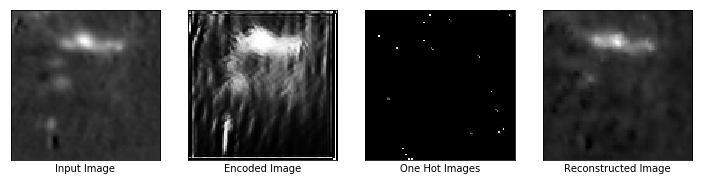

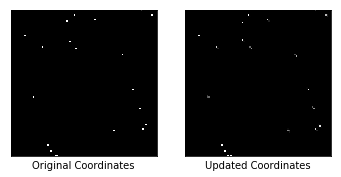

Epochs: 180, Loss: 0.002749526873230934
Similarity scores: [0.5455167  0.02384684 0.94844246 0.09121042 0.18432924 0.15312473
 0.00540729 0.02319046 0.11063242 0.03526299 0.12947874 0.00460417
 0.02434878 0.11984046 0.11375196 0.2763599  0.00536829 0.09500264
 0.83626723 0.02492882]
Updated Coordinates: [[[0.2511536 0.9285476]]]
Gradient min:-0.0016502038342878222, max:0.0015619162004441023



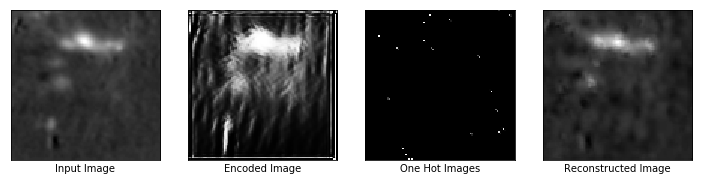

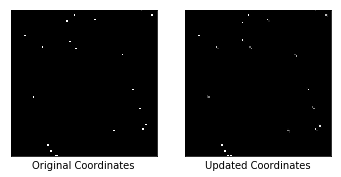

Epochs: 190, Loss: 0.0029348591342568398
Similarity scores: [0.701369   0.0190294  0.9485494  0.08169232 0.16640256 0.14625435
 0.00465275 0.01919292 0.08496767 0.02976092 0.11556101 0.00611296
 0.0211658  0.10798033 0.09201758 0.2852507  0.00706102 0.06296414
 0.8578213  0.02515415]
Updated Coordinates: [[[0.25082132 0.928853  ]]]
Gradient min:-0.002273646416142583, max:0.00182134669739753



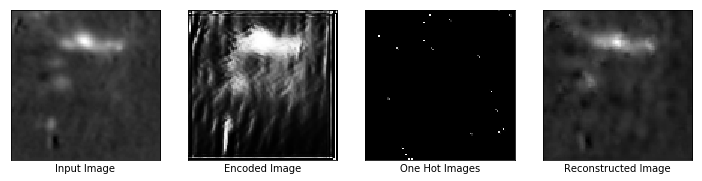

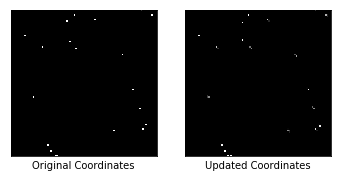

Epochs: 200, Loss: 0.0030909599736332893
Similarity scores: [0.7510326  0.01918598 0.94822556 0.08861336 0.14430013 0.18126455
 0.00546135 0.03213808 0.07129396 0.02253995 0.09633189 0.004355
 0.02107825 0.10156202 0.11500066 0.27829826 0.00485738 0.03891119
 0.8843114  0.01542665]
Updated Coordinates: [[[0.2506676 0.9289755]]]
Gradient min:-0.0025070011615753174, max:0.0017198973800987005



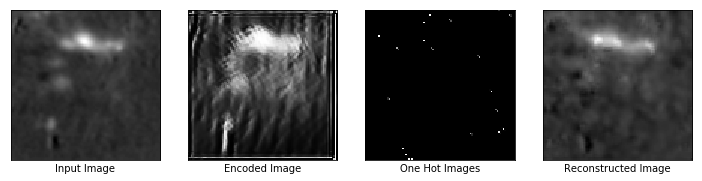

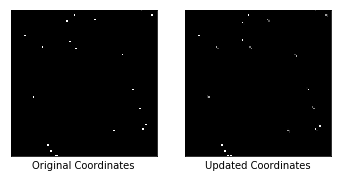

Epochs: 210, Loss: 0.0024015242233872414
Similarity scores: [0.51643    0.05373836 0.9092441  0.16870308 0.2135133  0.18543017
 0.02313891 0.04479912 0.08836073 0.06890951 0.17187975 0.0126917
 0.06204879 0.14989689 0.12376042 0.32857773 0.01285003 0.16229784
 0.666392   0.06054761]
Updated Coordinates: [[[0.25118873 0.9284518 ]]]
Gradient min:-3.662535164039582e-05, max:0.00035182267311029136



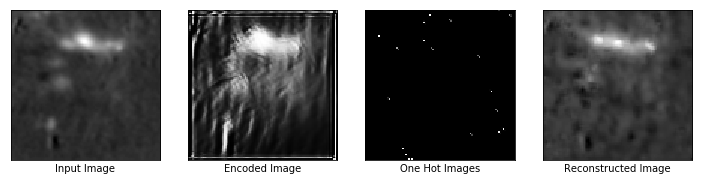

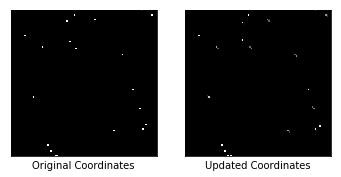

Epochs: 220, Loss: 0.0024758270010352135
Similarity scores: [0.6015113  0.04853456 0.8745783  0.14973782 0.20132072 0.1159234
 0.01788077 0.03461701 0.09703447 0.05859784 0.13523538 0.01867119
 0.0547724  0.14385393 0.0758322  0.3476775  0.02607304 0.30648375
 0.8312938  0.03979894]
Updated Coordinates: [[[0.25127447 0.9283635 ]]]
Gradient min:-5.1644612540258095e-05, max:0.0006227236008271575



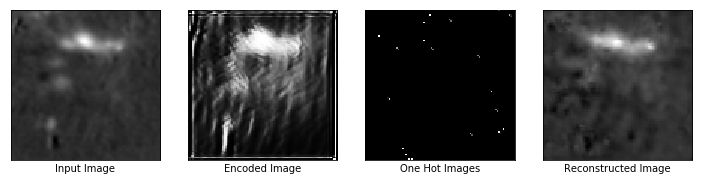

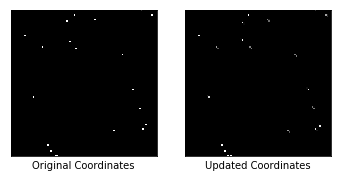

Epochs: 230, Loss: 0.002218331443145871
Similarity scores: [0.43034792 0.03027429 0.9069699  0.14382939 0.19205283 0.10947596
 0.00854046 0.02551818 0.08848322 0.03963734 0.12190917 0.01628338
 0.03966612 0.13839515 0.10570996 0.32490563 0.02125616 0.33127806
 0.834338   0.05352079]
Updated Coordinates: [[[0.25111407 0.9285165 ]]]
Gradient min:-0.0002132896042894572, max:0.00018936663400381804



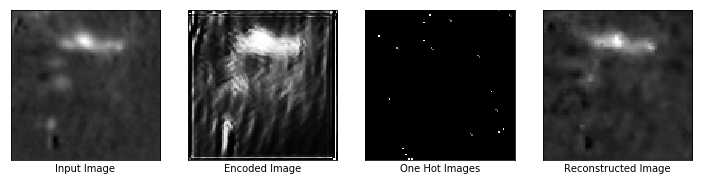

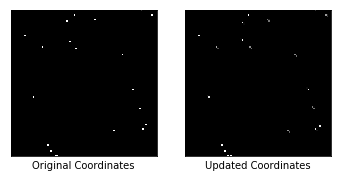

Epochs: 240, Loss: 0.00225060130469501
Similarity scores: [0.53524405 0.0319441  0.9221588  0.18054287 0.17334062 0.10230681
 0.01633438 0.0228602  0.07415946 0.03583334 0.11667082 0.02271335
 0.04303671 0.11354193 0.10766876 0.23497078 0.05185938 0.28317133
 0.888642   0.05222286]
Updated Coordinates: [[[0.25102726 0.9285912 ]]]
Gradient min:-0.0003884767647832632, max:0.0001286771585000679



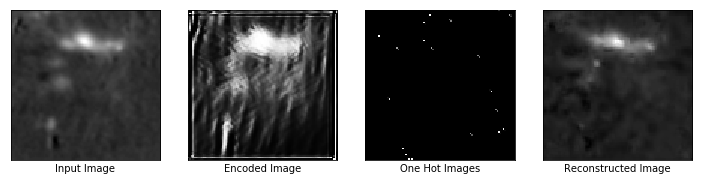

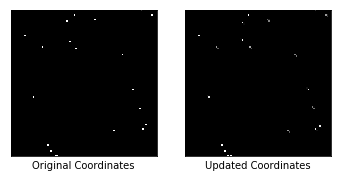

Epochs: 250, Loss: 0.002208170248195529
Similarity scores: [0.4476406  0.03061489 0.8894061  0.15649281 0.19092564 0.14392209
 0.00884426 0.03257745 0.08148754 0.0416849  0.12862578 0.01822054
 0.03909384 0.13756245 0.06225994 0.2368529  0.02273282 0.2615516
 0.8823172  0.04273546]
Updated Coordinates: [[[0.25135773 0.9282516 ]]]
Gradient min:-0.0006227983976714313, max:0.0005389039288274944



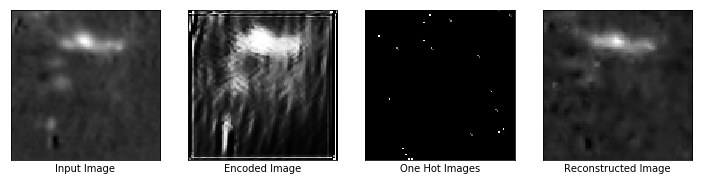

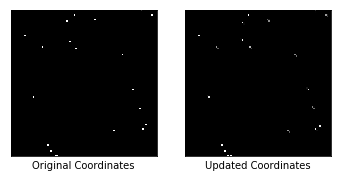

Epochs: 260, Loss: 0.0023047339636832476
Similarity scores: [0.5381686  0.02401658 0.9066195  0.14291054 0.14335673 0.16512725
 0.01873752 0.01628372 0.10361242 0.02578579 0.1117006  0.04393308
 0.03226009 0.14000568 0.07849129 0.25775713 0.06791545 0.32754955
 0.8783684  0.06879675]
Updated Coordinates: [[[0.2509937  0.92860466]]]
Gradient min:-0.0009654930327087641, max:0.0009117464069277048



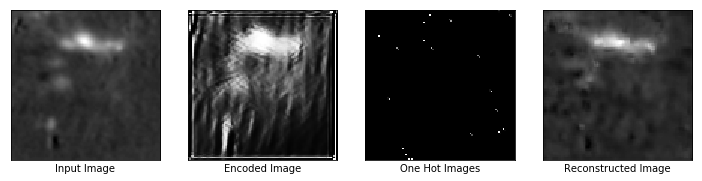

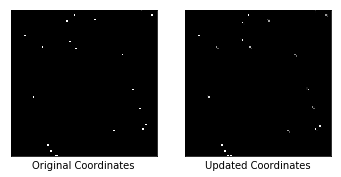

Epochs: 270, Loss: 0.0021486361511051655
Similarity scores: [0.5337052  0.03486229 0.8917618  0.19150816 0.15718976 0.20043762
 0.01515626 0.02182007 0.10778125 0.04015682 0.13117343 0.03362452
 0.04603069 0.17812505 0.10095015 0.23269849 0.03707484 0.3400095
 0.8631262  0.09059129]
Updated Coordinates: [[[0.2509981 0.9285925]]]
Gradient min:-0.0003426985931582749, max:0.0003720202948898077



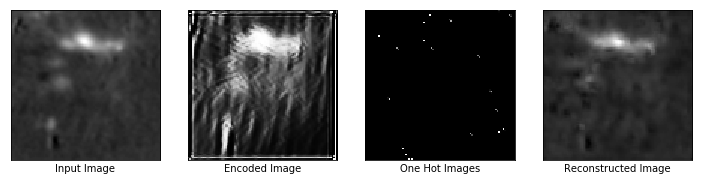

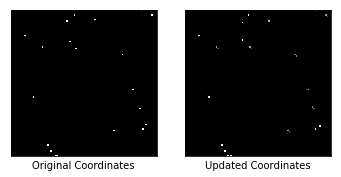

Epochs: 280, Loss: 0.0020993156358599663
Similarity scores: [0.6711935  0.03546103 0.906242   0.17064035 0.18956988 0.15224367
 0.02572201 0.05287384 0.09598483 0.04176097 0.14352468 0.06962835
 0.05149151 0.17227623 0.09031022 0.23539408 0.0620563  0.2595815
 0.88679177 0.07346627]
Updated Coordinates: [[[0.25086558 0.9287251 ]]]
Gradient min:-0.0006334958015941083, max:0.0004903087392449379



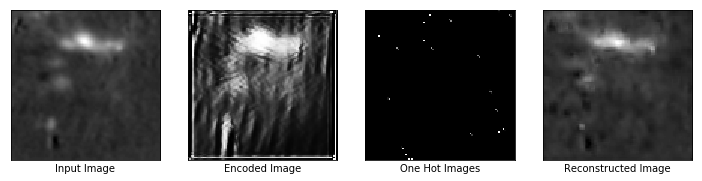

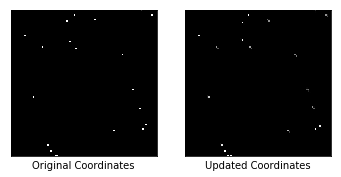

Epochs: 290, Loss: 0.0020932338666170835
Similarity scores: [0.6464094  0.04395182 0.89712906 0.24329402 0.16129945 0.21703738
 0.0061709  0.03397576 0.09767219 0.04921063 0.12926868 0.04421193
 0.05594338 0.17447978 0.07672872 0.19326612 0.05793929 0.26537228
 0.87769943 0.09895252]
Updated Coordinates: [[[0.25039393 0.92919236]]]
Gradient min:-0.00037280170363374054, max:0.000620866019744426



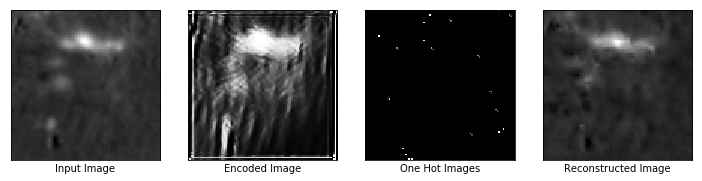

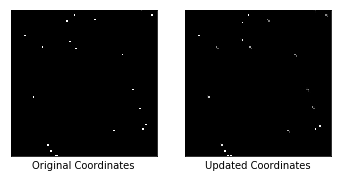

Epochs: 300, Loss: 0.002082665916532278
Similarity scores: [0.71358114 0.03143116 0.9165111  0.22282061 0.12133985 0.17336532
 0.0113104  0.01980527 0.07591633 0.03209057 0.10389663 0.02951688
 0.04658647 0.17151444 0.09976161 0.18676631 0.09683298 0.22643246
 0.9188825  0.11757714]
Updated Coordinates: [[[0.25033626 0.9292539 ]]]
Gradient min:-0.00017261385801248252, max:0.000397630559746176



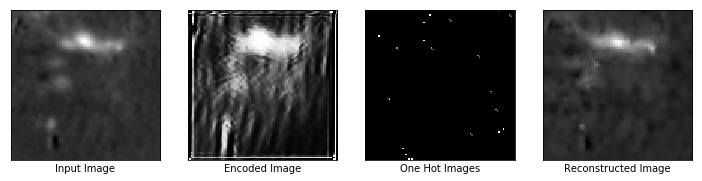

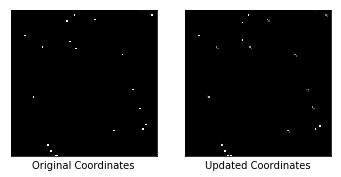

Epochs: 310, Loss: 0.002066146582365036
Similarity scores: [0.6436339  0.03097844 0.8760967  0.22489932 0.13362147 0.17426154
 0.01400152 0.02163343 0.08294547 0.03262481 0.11331308 0.04027024
 0.04519643 0.17855565 0.08310501 0.25261077 0.10338371 0.26199585
 0.8976632  0.07151407]
Updated Coordinates: [[[0.24995586 0.9297656 ]]]
Gradient min:-0.0007255726959556341, max:0.000661343103274703



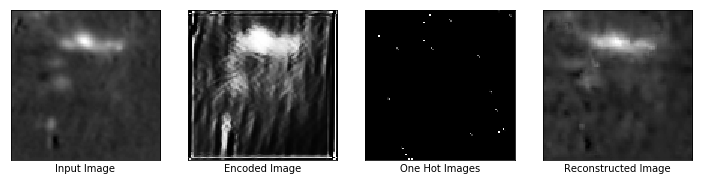

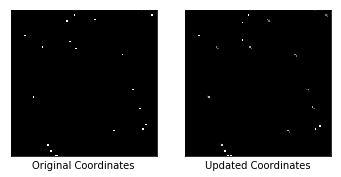

Epochs: 320, Loss: 0.0020991584751755
Similarity scores: [0.6038333  0.03010234 0.88499767 0.16086176 0.12006923 0.14969914
 0.02421621 0.01229428 0.08872755 0.03313744 0.11782665 0.0503437
 0.04513055 0.1462935  0.09572373 0.28777665 0.08348312 0.28149387
 0.9012416  0.07998551]
Updated Coordinates: [[[0.24969739 0.9295221 ]]]
Gradient min:-0.0009364326251670718, max:0.0009212483419105411



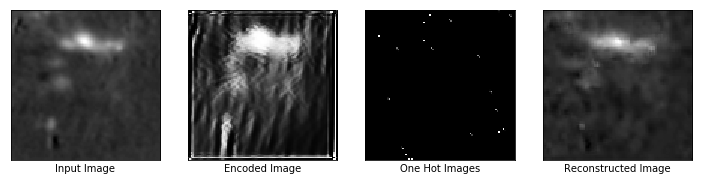

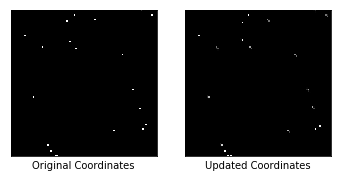

Epochs: 330, Loss: 0.0020938972011208534
Similarity scores: [0.545134   0.03659524 0.86124176 0.20933864 0.11722214 0.11478622
 0.02444018 0.0139794  0.06608479 0.04298211 0.12380131 0.04279447
 0.05341385 0.13979459 0.09004407 0.22821048 0.08043487 0.2443344
 0.84913915 0.08637339]
Updated Coordinates: [[[0.24976623 0.92912495]]]
Gradient min:-0.0010714444797486067, max:0.000845211383420974



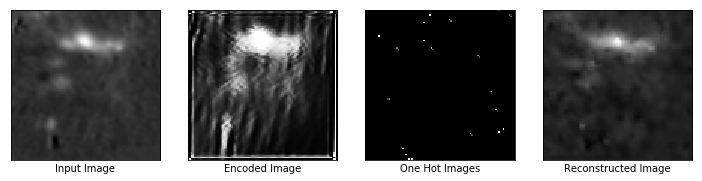

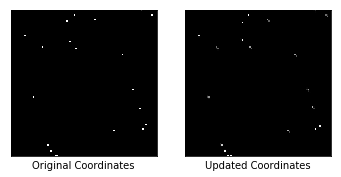

Epochs: 340, Loss: 0.0022194390185177326
Similarity scores: [0.5071605  0.02635274 0.8755834  0.20022994 0.0918634  0.0980802
 0.0257105  0.00731507 0.06476815 0.03185587 0.07910664 0.03133627
 0.0416615  0.12284779 0.08931107 0.20372242 0.05297694 0.21645705
 0.85225    0.06669946]
Updated Coordinates: [[[0.24963075 0.9290595 ]]]
Gradient min:-0.001455332268960774, max:0.001360802329145372



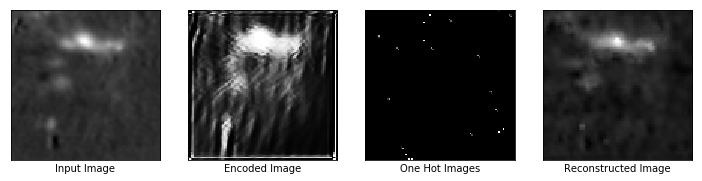

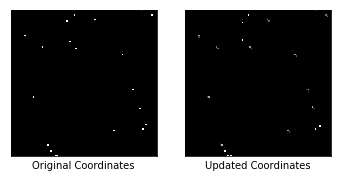

Epochs: 350, Loss: 0.002224596682935953
Similarity scores: [0.6190642  0.025662   0.91167635 0.16909562 0.08179806 0.09250539
 0.01815791 0.00291188 0.0605588  0.02323484 0.07779336 0.04028307
 0.03554593 0.14091334 0.08274267 0.16518427 0.09247335 0.21684197
 0.8708441  0.0578346 ]
Updated Coordinates: [[[0.24925606 0.92904717]]]
Gradient min:-0.0019150568405166268, max:0.0013405999634414911



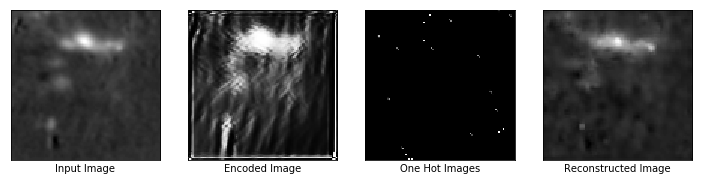

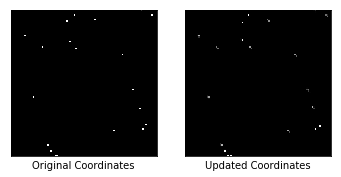

Epochs: 360, Loss: 0.0019072482828050852
Similarity scores: [0.5843943  0.04320429 0.8906898  0.20982708 0.10810643 0.09344555
 0.03698825 0.00553791 0.06745212 0.0514395  0.11179785 0.04095853
 0.05591821 0.1313643  0.10068748 0.21180989 0.10854904 0.18468006
 0.79280216 0.08530626]
Updated Coordinates: [[[0.24914137 0.9288064 ]]]
Gradient min:-0.00044533819891512394, max:0.00036425283178687096



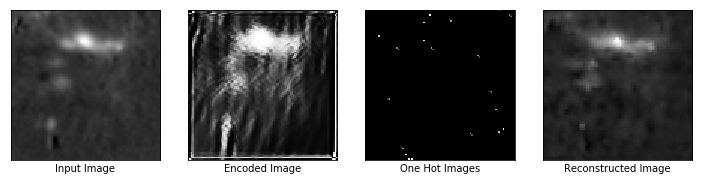

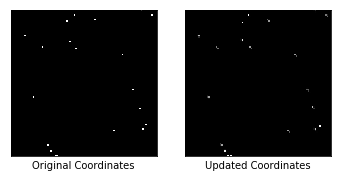

Epochs: 370, Loss: 0.0019572628661990166
Similarity scores: [0.5975227  0.04019022 0.8870504  0.23488244 0.09708294 0.11165069
 0.03417236 0.00301315 0.06401335 0.04094992 0.10689839 0.04205807
 0.05215328 0.1407577  0.08510569 0.16219208 0.16161913 0.19985162
 0.7902053  0.07411121]
Updated Coordinates: [[[0.24894239 0.92840976]]]
Gradient min:-0.0007935674511827528, max:0.000782604853156954



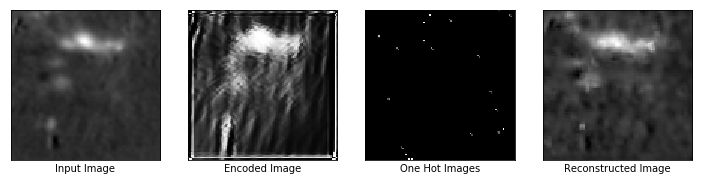

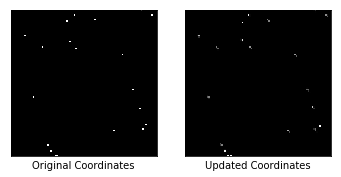

Epochs: 380, Loss: 0.0018741295207291842
Similarity scores: [0.7680266  0.04266835 0.89968485 0.2492048  0.0987986  0.11724138
 0.05294722 0.00182615 0.07154277 0.03732013 0.11326861 0.05455324
 0.06594193 0.14005913 0.09679297 0.17668147 0.16135417 0.19520739
 0.80387187 0.09465489]
Updated Coordinates: [[[0.24850915 0.92784804]]]
Gradient min:-0.0003063904878217727, max:0.00020901740936096758



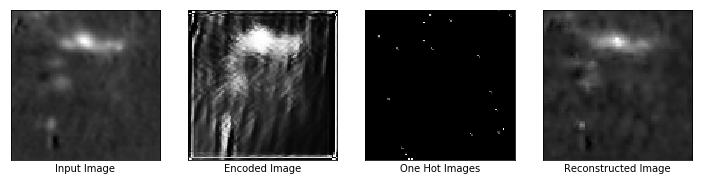

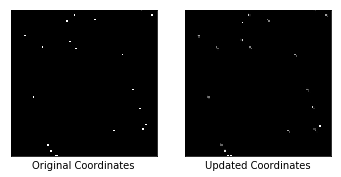

Epochs: 390, Loss: 0.0018324278062209487
Similarity scores: [0.7840736  0.03645205 0.89298004 0.2336128  0.07734338 0.1320852
 0.03974667 0.00175142 0.06115207 0.02712038 0.08627454 0.08723288
 0.05767841 0.14807473 0.09822364 0.15402275 0.23624732 0.18231535
 0.81466067 0.11471847]
Updated Coordinates: [[[0.2480687 0.9280327]]]
Gradient min:-0.00031189253786578774, max:0.0001476150209782645



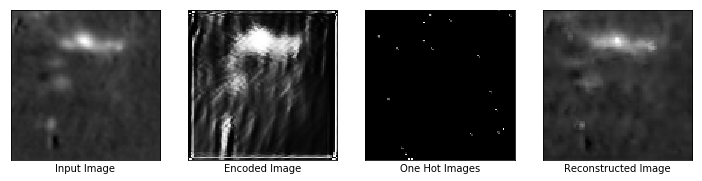

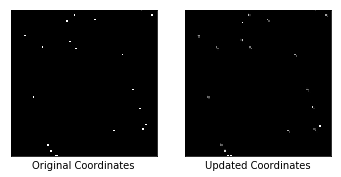

Epochs: 400, Loss: 0.0021237607579678297
Similarity scores: [0.7099715  0.03136044 0.9247652  0.19779767 0.05978215 0.06936627
 0.02517802 0.00160908 0.04106776 0.02524405 0.06376646 0.12664416
 0.04353383 0.10878983 0.08800311 0.1196802  0.31278908 0.1797815
 0.8749369  0.07096821]
Updated Coordinates: [[[0.2479489  0.92806196]]]
Gradient min:-0.0004402651102282107, max:0.0005181242595426738



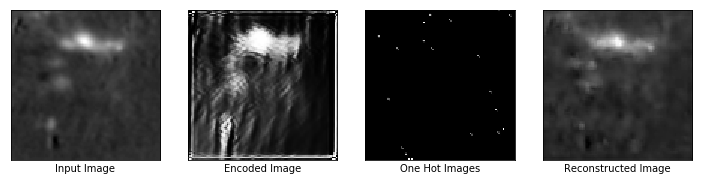

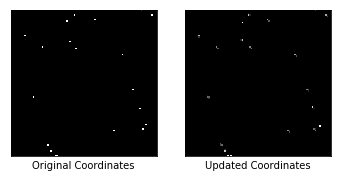

Epochs: 410, Loss: 0.002666570944711566
Similarity scores: [0.6899012  0.04046458 0.87537307 0.22145256 0.05316553 0.08161434
 0.04995266 0.00234285 0.02588913 0.03567326 0.07286432 0.19608808
 0.06035356 0.09894223 0.0373699  0.07917761 0.2882562  0.15549037
 0.8486255  0.09448387]
Updated Coordinates: [[[0.24814995 0.92758286]]]
Gradient min:-0.0009178834152407944, max:0.0006612460711039603



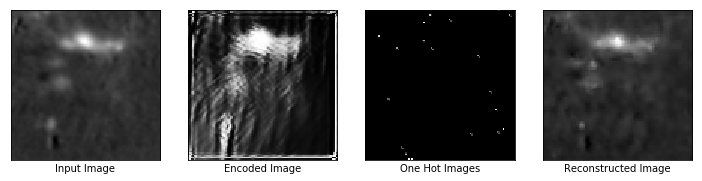

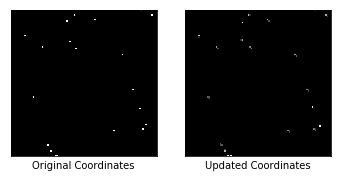

Epochs: 420, Loss: 0.0021917291451245546
Similarity scores: [0.78992593 0.04108364 0.82650244 0.2570441  0.05482956 0.08113361
 0.04250369 0.00204308 0.03173234 0.03226157 0.06841869 0.13376577
 0.06240867 0.12136256 0.0621987  0.07842397 0.27528876 0.15148158
 0.86548865 0.12697859]
Updated Coordinates: [[[0.2479207 0.9273597]]]
Gradient min:-0.0006268501165322959, max:0.0005245197098702192



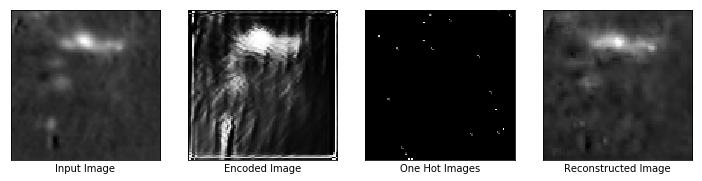

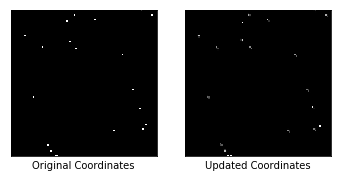

Epochs: 430, Loss: 0.002345711225643754
Similarity scores: [0.7177964  0.04289326 0.8639667  0.2262688  0.06345166 0.06104988
 0.03035353 0.00274923 0.02285556 0.03250519 0.07063038 0.22595535
 0.05859298 0.09913804 0.04562156 0.08583003 0.3420874  0.11280835
 0.799185   0.09839156]
Updated Coordinates: [[[0.24789217 0.9273022 ]]]
Gradient min:-0.0006346275331452489, max:6.486639176728204e-05



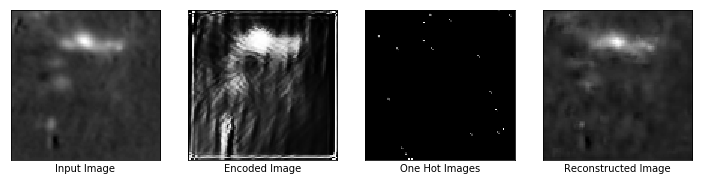

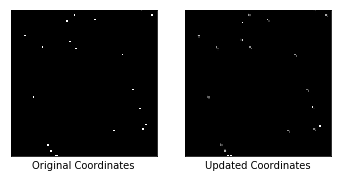

Epochs: 440, Loss: 0.002510105026885867
Similarity scores: [0.77047783 0.03890869 0.8699104  0.24044359 0.05792085 0.06094277
 0.03254269 0.00220575 0.02302006 0.02726022 0.06801993 0.19925435
 0.05391379 0.0948388  0.0538271  0.07176174 0.27471575 0.10155164
 0.8393577  0.07140642]
Updated Coordinates: [[[0.24749336 0.92746025]]]
Gradient min:-0.0015313399489969015, max:0.0007339197909459472



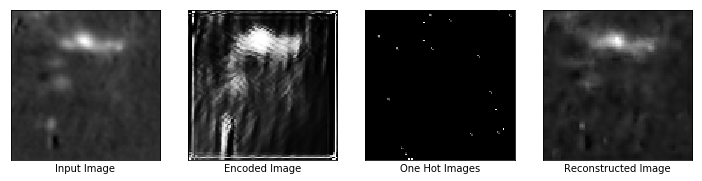

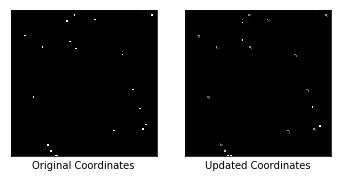

Epochs: 450, Loss: 0.0023601318243891
Similarity scores: [0.7146799  0.03239538 0.84961396 0.20249125 0.05509988 0.0719837
 0.02930233 0.00165994 0.0286027  0.02544334 0.07139431 0.16286306
 0.04312683 0.09440892 0.05465664 0.083404   0.2660898  0.08442751
 0.80349725 0.08072887]
Updated Coordinates: [[[0.24742256 0.9275708 ]]]
Gradient min:-0.0012994345743209124, max:0.0010062799556180835



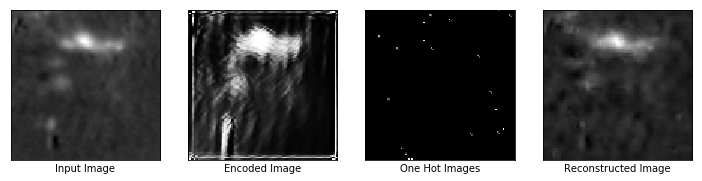

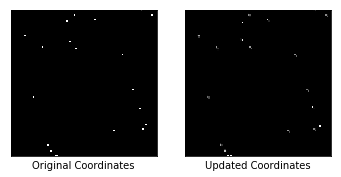

Epochs: 460, Loss: 0.0034494297578930855
Similarity scores: [0.7599099  0.02589912 0.8416755  0.1747428  0.04690928 0.06295221
 0.04502092 0.00383009 0.01627205 0.02018748 0.05660655 0.15287136
 0.03221887 0.07368664 0.07491533 0.08466897 0.26831177 0.11228059
 0.8441725  0.04493294]
Updated Coordinates: [[[0.24733807 0.92773104]]]
Gradient min:-0.004081173799932003, max:0.003559877397492528



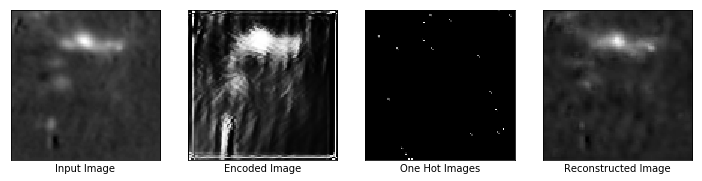

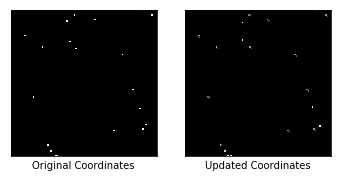

Epochs: 470, Loss: 0.0024087466299533844
Similarity scores: [0.7950894  0.03444206 0.8565909  0.19897687 0.05565495 0.0688483
 0.04745791 0.00216822 0.02144332 0.02839472 0.07045956 0.15448423
 0.04154633 0.08989599 0.06578549 0.0703926  0.25636572 0.05397486
 0.8115916  0.03282264]
Updated Coordinates: [[[0.24732727 0.92784256]]]
Gradient min:-0.0027000736445188522, max:0.0023786730598658323



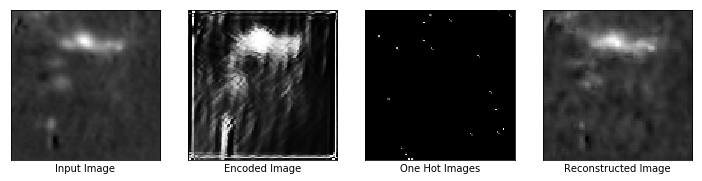

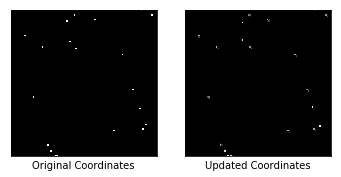

Epochs: 480, Loss: 0.0024054718669503927
Similarity scores: [0.7812446  0.03366452 0.8647786  0.183702   0.05729093 0.073746
 0.03990523 0.00476316 0.02643931 0.02685617 0.06650271 0.14374985
 0.0395496  0.07666001 0.0709161  0.08829482 0.2228384  0.05846886
 0.8620904  0.04519738]
Updated Coordinates: [[[0.24725    0.92785907]]]
Gradient min:-0.0014248276129364967, max:0.0008435763302259147



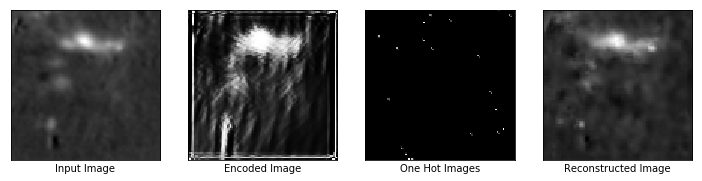

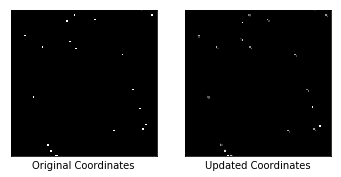

Epochs: 490, Loss: 0.0022419181186705828
Similarity scores: [0.6986189  0.03925547 0.86861503 0.17685604 0.06869772 0.05656558
 0.03993205 0.00364381 0.02637204 0.03509562 0.10370691 0.10385175
 0.04682056 0.06414901 0.06327385 0.09102739 0.20522875 0.14364944
 0.8285818  0.0384216 ]
Updated Coordinates: [[[0.2474691 0.9278774]]]
Gradient min:-0.0010695586679503322, max:0.0009276121854782104



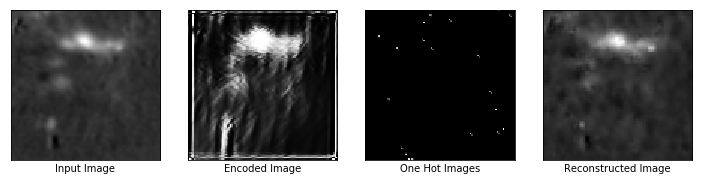

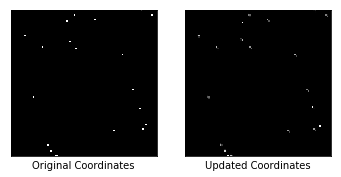

Epochs: 500, Loss: 0.002028149552643299
Similarity scores: [0.7198609  0.03615073 0.82804376 0.17459217 0.06070946 0.07258723
 0.03660457 0.00218523 0.02026275 0.02668189 0.06946851 0.11307293
 0.04256035 0.05531152 0.04705238 0.08616261 0.2718444  0.10820293
 0.83571565 0.02492723]
Updated Coordinates: [[[0.24743824 0.9277849 ]]]
Gradient min:-0.0012876060791313648, max:0.0009862188016995788



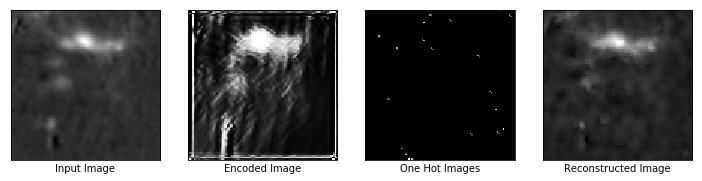

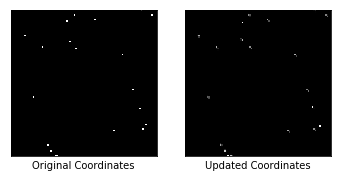

Epochs: 510, Loss: 0.002343944041058421
Similarity scores: [0.6909618  0.03671608 0.8601192  0.16937038 0.06304851 0.07646346
 0.03720848 0.01231992 0.03358167 0.03149654 0.07022078 0.11279278
 0.04334108 0.07692984 0.06112763 0.08380131 0.24298677 0.11527517
 0.8579258  0.04430028]
Updated Coordinates: [[[0.247417   0.92787856]]]
Gradient min:-0.002465156139805913, max:0.002284369198605418



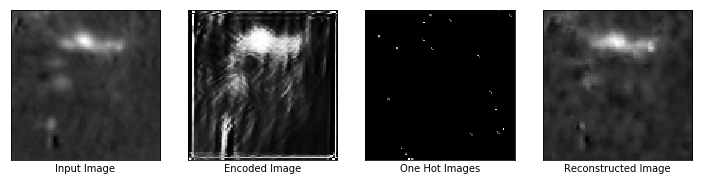

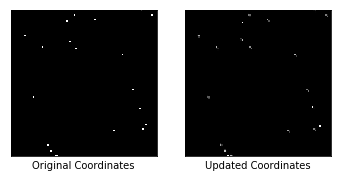

Epochs: 520, Loss: 0.0019101062789559364
Similarity scores: [0.716161   0.04265114 0.8764783  0.16232938 0.07113754 0.08378281
 0.03481031 0.0047679  0.03929672 0.0346048  0.08194537 0.07997064
 0.04915884 0.07669058 0.08562529 0.10829481 0.29942918 0.14583984
 0.8731845  0.0490866 ]
Updated Coordinates: [[[0.24733603 0.92773026]]]
Gradient min:-0.0008686445653438568, max:0.0003683280956465751



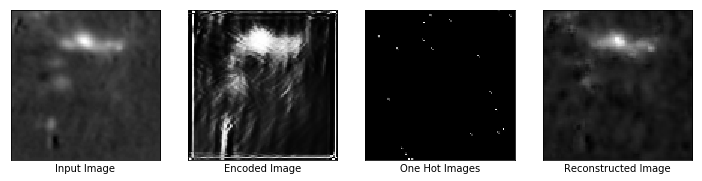

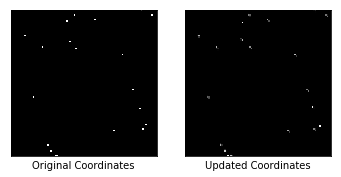

Epochs: 530, Loss: 0.0019141872180625796
Similarity scores: [0.71777314 0.03703199 0.84593326 0.16128595 0.05898153 0.07791301
 0.03660359 0.00909312 0.02671481 0.03465934 0.0738076  0.08568809
 0.04374326 0.04902199 0.05878149 0.10728142 0.19515693 0.07541694
 0.8767547  0.04407927]
Updated Coordinates: [[[0.24726519 0.9277558 ]]]
Gradient min:-0.0010513750603422523, max:0.0007679986883886158



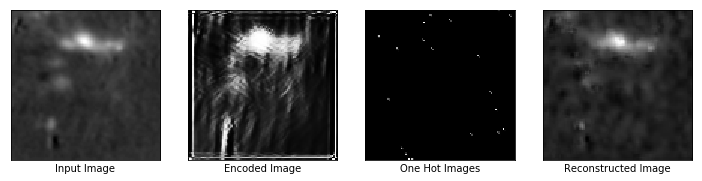

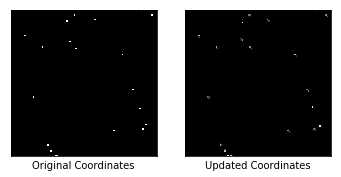

Epochs: 540, Loss: 0.0016673190984874964
Similarity scores: [0.7352991  0.04450525 0.78905016 0.15395974 0.07116999 0.06632046
 0.04165059 0.00723238 0.03393762 0.04082027 0.08035176 0.0696402
 0.05223539 0.06065543 0.07204378 0.11784662 0.24681902 0.07716161
 0.88603216 0.05984747]
Updated Coordinates: [[[0.24717616 0.9277329 ]]]
Gradient min:-0.0003782917920034379, max:0.00026916604838334024



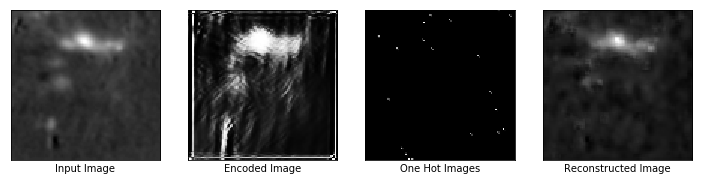

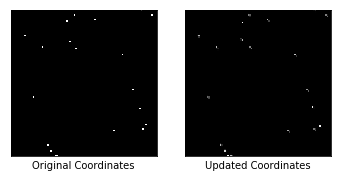

Epochs: 550, Loss: 0.0019633560441434383
Similarity scores: [0.7283555  0.03463935 0.83860064 0.13980271 0.05664681 0.07762101
 0.02945777 0.00670963 0.02237812 0.03318525 0.0701849  0.08067209
 0.04197794 0.04048904 0.05028853 0.08557904 0.25788164 0.06979209
 0.9090441  0.02699546]
Updated Coordinates: [[[0.24716575 0.9278226 ]]]
Gradient min:-0.0005418820073828101, max:0.0005063274875283241



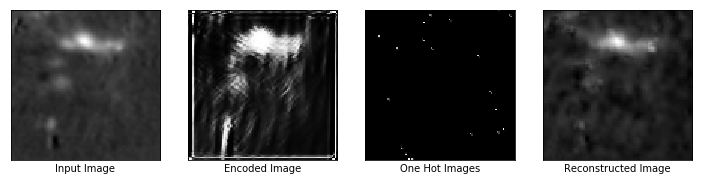

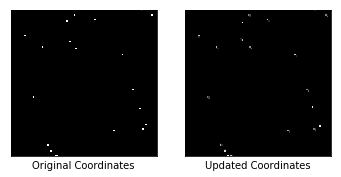

Epochs: 560, Loss: 0.003524262923747301
Similarity scores: [0.7348008  0.03447945 0.79862106 0.10833582 0.05634211 0.04466705
 0.03931382 0.00527046 0.0134897  0.03336009 0.06804299 0.11123145
 0.04145655 0.02538064 0.04117293 0.09770119 0.13254946 0.0726313
 0.90598565 0.02505624]
Updated Coordinates: [[[0.24726057 0.927923  ]]]
Gradient min:-0.003948144149035215, max:0.004395348019897938



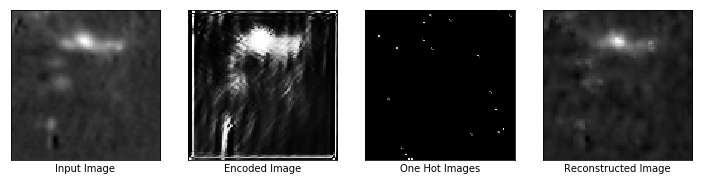

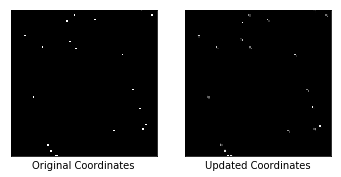

Epochs: 570, Loss: 0.0023875038605183363
Similarity scores: [0.7489859  0.03616501 0.71833843 0.10732998 0.05936553 0.07816054
 0.03333563 0.01136139 0.0250852  0.03008932 0.07392343 0.07425202
 0.03976586 0.04451465 0.04316441 0.0674746  0.16743739 0.06308755
 0.8820231  0.0118104 ]
Updated Coordinates: [[[0.24745467 0.92777014]]]
Gradient min:-0.0019012365955859423, max:0.0020979091059416533



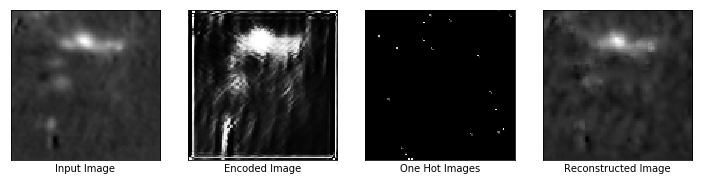

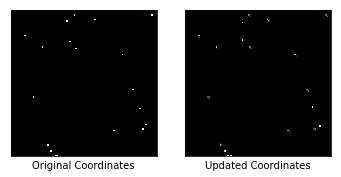

Epochs: 580, Loss: 0.002849866868928075
Similarity scores: [0.7931573  0.02748191 0.76862526 0.09874944 0.04938381 0.05454936
 0.02039272 0.00626073 0.01813611 0.02434712 0.05593826 0.07189965
 0.03586405 0.03923943 0.04755343 0.07185157 0.15636007 0.05785758
 0.93191963 0.01265992]
Updated Coordinates: [[[0.2473369 0.9276592]]]
Gradient min:-0.00218395097181201, max:0.0024072087835520506



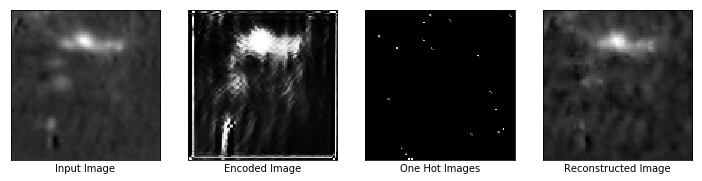

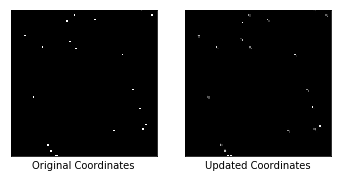

Epochs: 590, Loss: 0.0028221295215189457
Similarity scores: [0.7501805  0.02580293 0.7088539  0.09175514 0.04905681 0.04188031
 0.02021197 0.00770443 0.01882423 0.01969458 0.05183597 0.03169594
 0.02985274 0.0274045  0.06183873 0.07713211 0.14323474 0.06539094
 0.9581803  0.01274781]
Updated Coordinates: [[[0.24727942 0.9278215 ]]]
Gradient min:-0.0027474926318973303, max:0.003883124329149723



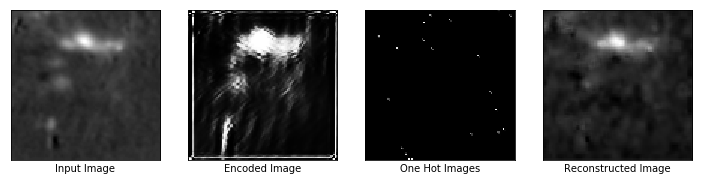

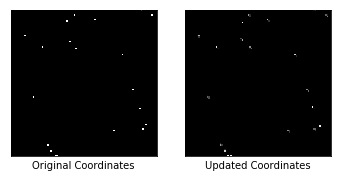

Epochs: 600, Loss: 0.0032234450336545706
Similarity scores: [0.6126433  0.0175896  0.7764348  0.05784827 0.04351842 0.02288868
 0.01523648 0.03052874 0.00767635 0.01754436 0.04434472 0.05033211
 0.02211699 0.00748284 0.03117953 0.07242102 0.08439272 0.04045575
 0.9724165  0.00718644]
Updated Coordinates: [[[0.24751596 0.9278814 ]]]
Gradient min:-0.002642688574269414, max:0.003174157114699483



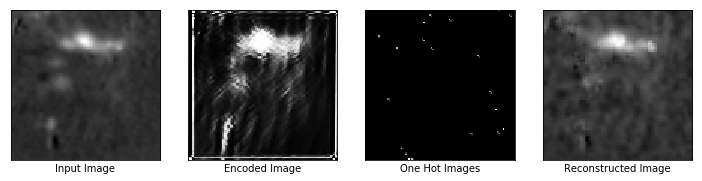

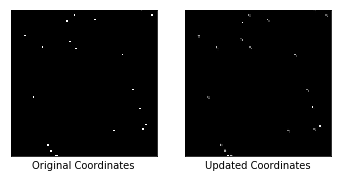

Epochs: 610, Loss: 0.0019885811489075422
Similarity scores: [0.7198781  0.03042803 0.78434974 0.08414776 0.0683062  0.05431276
 0.01854235 0.01268477 0.03128827 0.03168733 0.06772728 0.04238775
 0.03442293 0.02778571 0.07647016 0.1047308  0.2500155  0.03792457
 0.9115709  0.01196124]
Updated Coordinates: [[[0.24729411 0.92820144]]]
Gradient min:-0.0005086539313197136, max:0.0007941267685964704



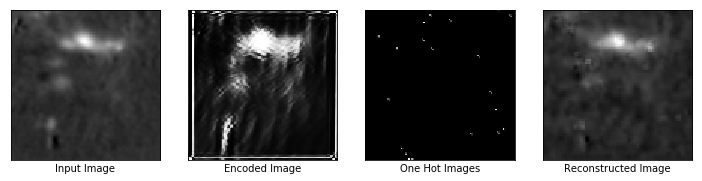

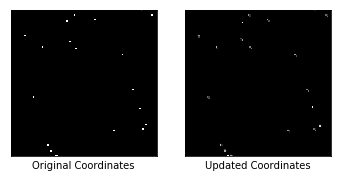

Epochs: 620, Loss: 0.0018626911332830787
Similarity scores: [0.6490856  0.03277816 0.77176714 0.10040426 0.06960575 0.07353368
 0.02124977 0.03016865 0.02761625 0.02825267 0.06865016 0.02799246
 0.03912793 0.02435143 0.06225994 0.10998585 0.22800839 0.04517789
 0.92735934 0.01437417]
Updated Coordinates: [[[0.2471875 0.92824  ]]]
Gradient min:-0.0003854311362374574, max:0.0005322554497979581



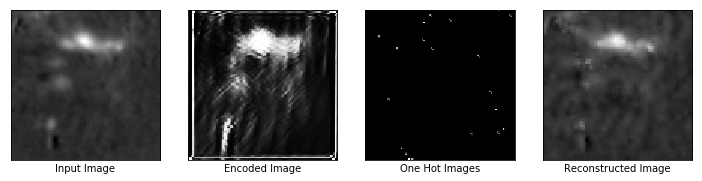

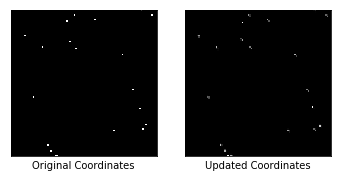

Epochs: 630, Loss: 0.0020324336364865303
Similarity scores: [0.7291627  0.03850706 0.7660774  0.10500235 0.07442272 0.06785291
 0.01979578 0.00676629 0.02949656 0.03745695 0.08214435 0.03258473
 0.04316589 0.0339365  0.07441003 0.10677412 0.22705975 0.06505127
 0.9463084  0.01547871]
Updated Coordinates: [[[0.24716501 0.928048  ]]]
Gradient min:-0.0010670351330190897, max:0.0006875571561977267



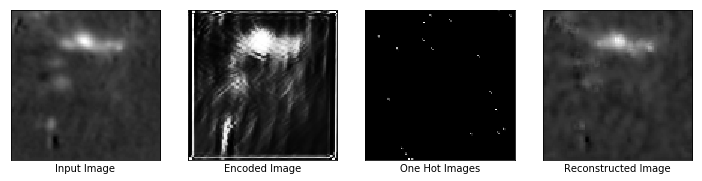

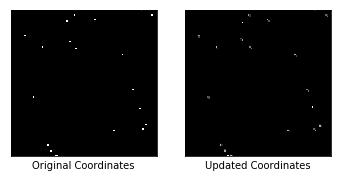

Epochs: 640, Loss: 0.001889432198368013
Similarity scores: [0.7420723  0.04024146 0.78475404 0.11906422 0.08017948 0.0495393
 0.02793744 0.00515436 0.04164178 0.04537727 0.08441801 0.05872984
 0.05068612 0.03132952 0.08421411 0.1401509  0.17471251 0.05341445
 0.9305904  0.02241843]
Updated Coordinates: [[[0.2472215 0.9279382]]]
Gradient min:-0.0010488973930478096, max:0.00064542714972049



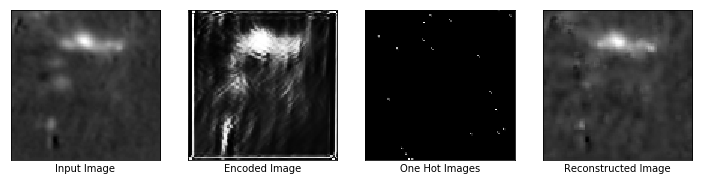

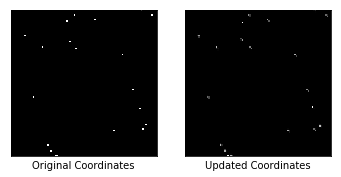

Epochs: 650, Loss: 0.0015958343865349889
Similarity scores: [0.71220046 0.04091003 0.7650332  0.11763429 0.08322804 0.08693196
 0.02334762 0.03084536 0.03630264 0.03995606 0.08211146 0.04421573
 0.05019247 0.02824744 0.09285634 0.11451605 0.11131418 0.07968565
 0.9475216  0.02843914]
Updated Coordinates: [[[0.24720147 0.92788213]]]
Gradient min:-0.0006230867584235966, max:0.0006901893066242337



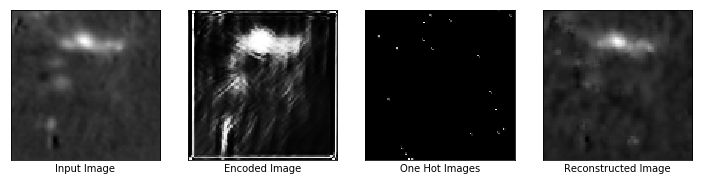

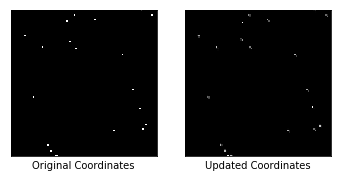

Epochs: 660, Loss: 0.002266331110149622
Similarity scores: [0.68600357 0.02668709 0.8238864  0.11018433 0.04974956 0.04674102
 0.02571654 0.0258299  0.02156292 0.02436084 0.05376973 0.02925819
 0.03389999 0.02121679 0.04774383 0.08468162 0.12677187 0.07986218
 0.9309076  0.01549357]
Updated Coordinates: [[[0.24726814 0.92783904]]]
Gradient min:-0.0015255901962518692, max:0.0010550660081207752



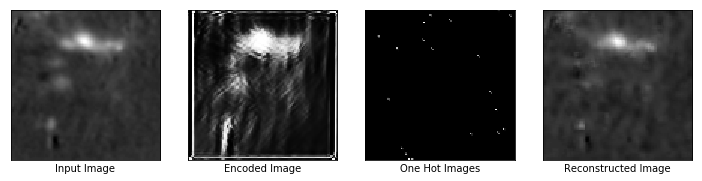

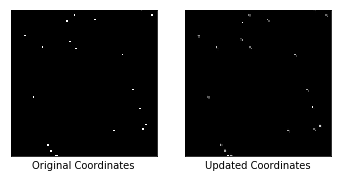

Epochs: 670, Loss: 0.0015295741613954306
Similarity scores: [0.7565524  0.04381512 0.7639505  0.13538098 0.08289697 0.06277688
 0.0398986  0.00561766 0.03328169 0.04657188 0.07759815 0.04022499
 0.05216974 0.03021536 0.07995071 0.10172484 0.13899636 0.05825727
 0.91227764 0.02360955]
Updated Coordinates: [[[0.24720336 0.92779595]]]
Gradient min:-0.0003928530786652118, max:9.136948938248679e-05



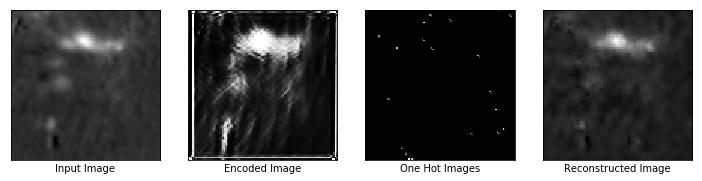

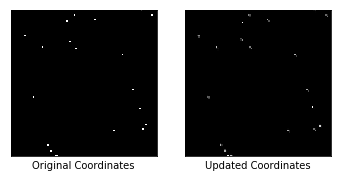

Epochs: 680, Loss: 0.0021067545749247074
Similarity scores: [0.69416744 0.03865485 0.7878265  0.1016714  0.06468622 0.0630018
 0.02622385 0.01581187 0.02204476 0.0365312  0.06661405 0.04241348
 0.04355893 0.02403674 0.07762799 0.09722012 0.12462471 0.08847257
 0.9245507  0.01988581]
Updated Coordinates: [[[0.24717383 0.9277605 ]]]
Gradient min:-0.0021654886659234762, max:0.0019777771085500717



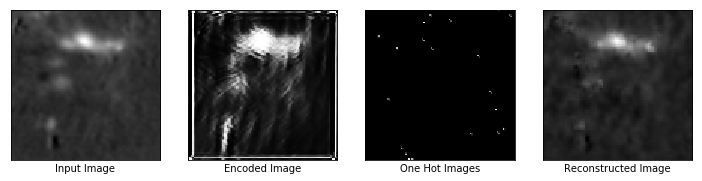

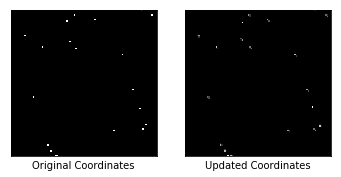

Epochs: 690, Loss: 0.001560264267027378
Similarity scores: [0.66962653 0.03587353 0.77351546 0.10787699 0.06928461 0.07683549
 0.02825853 0.02448199 0.02916149 0.03371443 0.06510836 0.04279524
 0.04258227 0.0274746  0.06428476 0.0835755  0.13479385 0.04191751
 0.90279686 0.02513539]
Updated Coordinates: [[[0.24724272 0.9277133 ]]]
Gradient min:-0.00015644318773411214, max:0.00032031722366809845



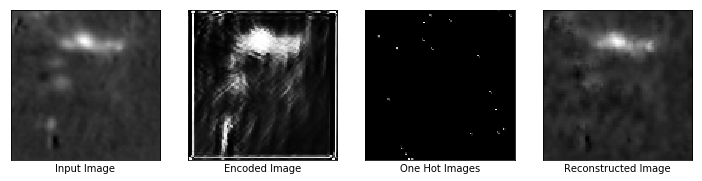

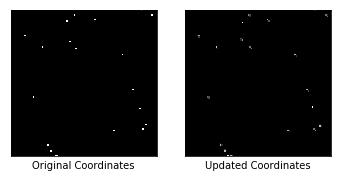

Epochs: 700, Loss: 0.0016658935928717256
Similarity scores: [0.7055917  0.03603352 0.77733606 0.09678754 0.06312012 0.06622226
 0.02831838 0.01943421 0.02268647 0.03429452 0.06859914 0.06717642
 0.04491445 0.01920486 0.06492694 0.07899503 0.13796732 0.06720854
 0.89011174 0.01837862]
Updated Coordinates: [[[0.2471113 0.9277122]]]
Gradient min:-0.0005017183721065521, max:0.0002608573413453996



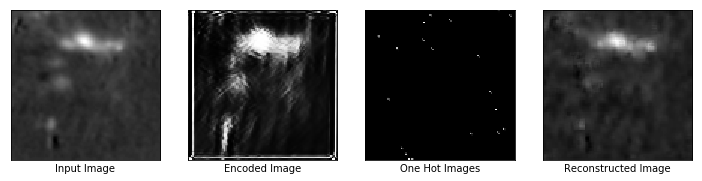

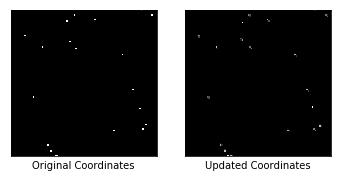

Epochs: 710, Loss: 0.0016705058515071869
Similarity scores: [0.6885484  0.03361122 0.79468805 0.08772364 0.06250457 0.05365116
 0.02800726 0.03064496 0.0208792  0.03282795 0.06941404 0.04001869
 0.03816075 0.01926051 0.06189866 0.07887243 0.13825682 0.06280606
 0.87831503 0.01353098]
Updated Coordinates: [[[0.24714062 0.9276588 ]]]
Gradient min:-0.00038566658622585237, max:0.0005569502245634794



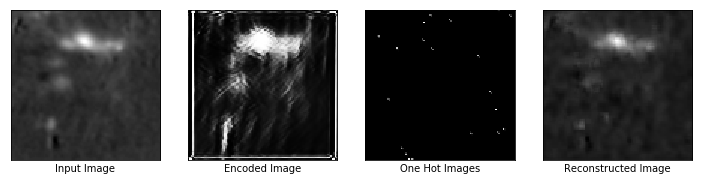

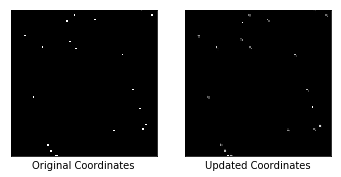

Epochs: 720, Loss: 0.0018379464745521545
Similarity scores: [0.70400137 0.02920524 0.7679581  0.07995215 0.06090372 0.06384397
 0.02274282 0.02305176 0.02415332 0.0314971  0.06625485 0.0319744
 0.03259548 0.02340391 0.0710314  0.07494295 0.14882964 0.03905724
 0.86204547 0.01855849]
Updated Coordinates: [[[0.24719197 0.92752385]]]
Gradient min:-0.0009126016520895064, max:0.001012540189549327



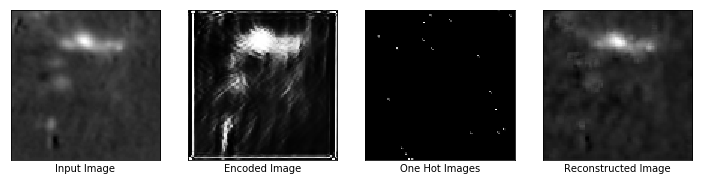

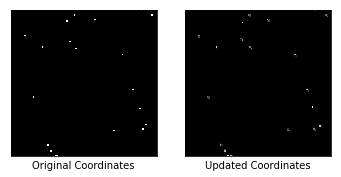

Epochs: 730, Loss: 0.00212572212330997
Similarity scores: [0.65618336 0.02790829 0.7896732  0.07109648 0.05766606 0.06306195
 0.02573654 0.01691273 0.02448742 0.02475702 0.05498756 0.03121352
 0.03292214 0.01612319 0.07394265 0.0671814  0.15665935 0.04470664
 0.8903984  0.01714962]
Updated Coordinates: [[[0.24706201 0.9274637 ]]]
Gradient min:-0.0014520519180223346, max:0.0012771296314895153



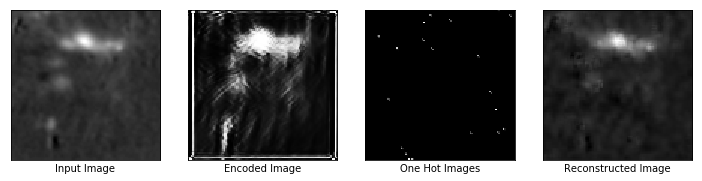

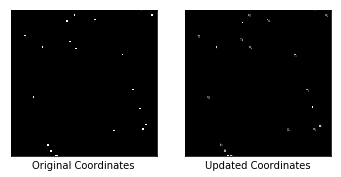

Epochs: 740, Loss: 0.001554266200400889
Similarity scores: [0.6610223  0.0344668  0.7964305  0.07783774 0.06362654 0.06926949
 0.02484167 0.01723557 0.0260015  0.02887447 0.06519544 0.02815977
 0.03736836 0.02217584 0.08573229 0.08081008 0.17288917 0.12163362
 0.84972095 0.01845821]
Updated Coordinates: [[[0.2470376 0.9273936]]]
Gradient min:-0.00028920473414473236, max:0.00043967488454654813



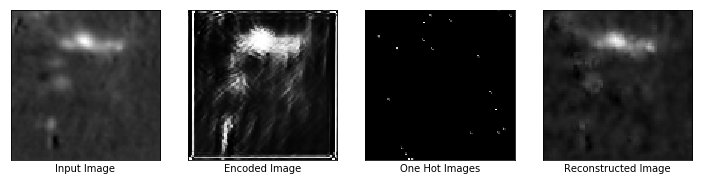

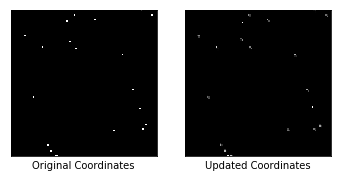

Epochs: 750, Loss: 0.0016162872780114412
Similarity scores: [0.6166365  0.03977677 0.7676487  0.07375006 0.07295819 0.09406735
 0.02269599 0.02779949 0.02506746 0.03338926 0.07282432 0.03737285
 0.04241021 0.02235315 0.08691899 0.09408495 0.20119798 0.03441402
 0.83321124 0.02066357]
Updated Coordinates: [[[0.24700223 0.927389  ]]]
Gradient min:-0.0003963595663663, max:0.00047953956527635455



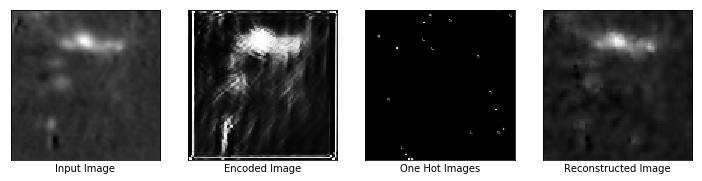

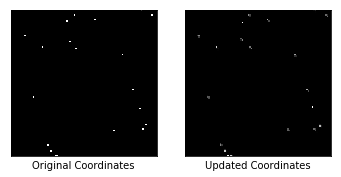

Epochs: 760, Loss: 0.0017043172847479582
Similarity scores: [0.62162584 0.03707301 0.7930155  0.08443597 0.07187681 0.08500107
 0.02355613 0.02868223 0.02728386 0.03249708 0.06899382 0.03899512
 0.04356211 0.01960929 0.08012123 0.10344778 0.13235018 0.03499095
 0.84880805 0.01867268]
Updated Coordinates: [[[0.24718738 0.9272929 ]]]
Gradient min:-0.0007859355537220836, max:0.0006209784769453108



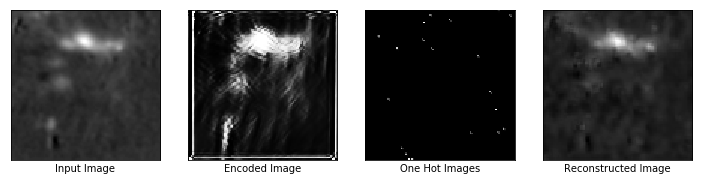

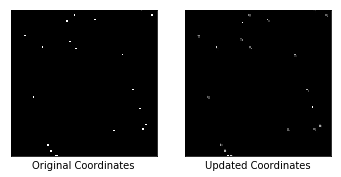

Epochs: 770, Loss: 0.001850983826443553
Similarity scores: [0.6517429  0.03371165 0.7648591  0.06706163 0.07345834 0.07920304
 0.02294538 0.00791591 0.02303982 0.03118717 0.06688731 0.02367399
 0.03740314 0.01255327 0.08196651 0.08220661 0.22017843 0.01398326
 0.9015893  0.01269443]
Updated Coordinates: [[[0.24716786 0.9275555 ]]]
Gradient min:-0.0008431848254986107, max:0.0001394552964484319



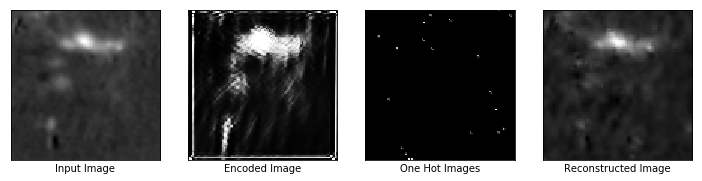

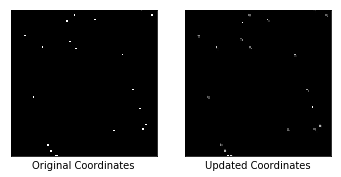

Epochs: 780, Loss: 0.003479674458503723
Similarity scores: [0.70514315 0.02174096 0.81217134 0.06020468 0.04453234 0.03484708
 0.01609777 0.01115773 0.00986164 0.02257197 0.04698957 0.01466974
 0.0229203  0.00795731 0.06028223 0.04640618 0.08296536 0.01092099
 0.93347156 0.00584482]
Updated Coordinates: [[[0.24734919 0.9274971 ]]]
Gradient min:-0.005241652484983206, max:0.0050572361797094345



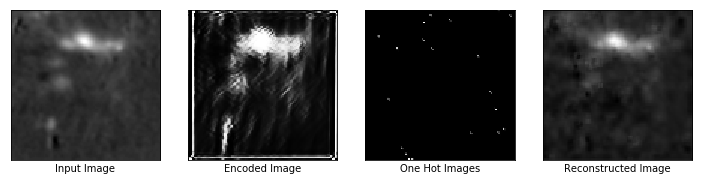

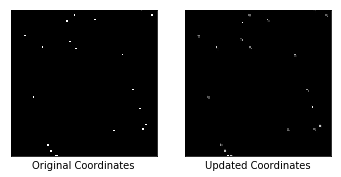

Epochs: 790, Loss: 0.0021266124676913023
Similarity scores: [0.5730216  0.02844535 0.7567171  0.05543452 0.06871962 0.07980828
 0.01572988 0.01420772 0.02703394 0.02628872 0.05922261 0.01679186
 0.02956402 0.01697334 0.10146923 0.08829607 0.17219117 0.04271533
 0.9142809  0.01398752]
Updated Coordinates: [[[0.24723159 0.9274986 ]]]
Gradient min:-0.0016361979069188237, max:0.002630201866850257



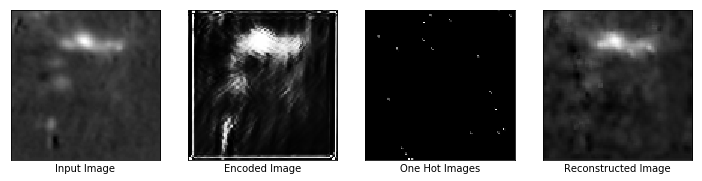

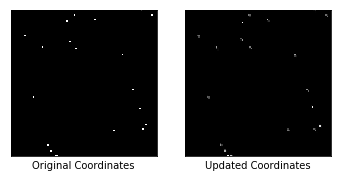

Epochs: 800, Loss: 0.002408185275271535
Similarity scores: [0.537902   0.02364117 0.8058976  0.07903691 0.05788641 0.06215147
 0.01068438 0.03248758 0.01762111 0.02299204 0.05331412 0.03473851
 0.02893571 0.01480017 0.06694841 0.0887997  0.08785418 0.05693675
 0.9410183  0.01526646]
Updated Coordinates: [[[0.24728644 0.92748845]]]
Gradient min:-0.0019315863028168678, max:0.0020003654062747955



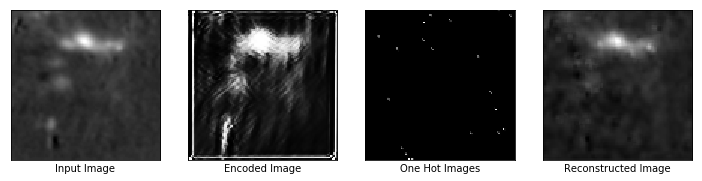

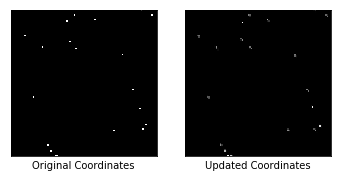

Epochs: 810, Loss: 0.002097354969009757
Similarity scores: [0.58220494 0.03431697 0.80631524 0.10071638 0.06554401 0.08627144
 0.01727908 0.03590067 0.02584084 0.03243003 0.06826597 0.03903197
 0.03874052 0.0227434  0.0760491  0.11021329 0.08954345 0.05559606
 0.9128764  0.0178264 ]
Updated Coordinates: [[[0.24719098 0.9273436 ]]]
Gradient min:-0.0017850648146122694, max:0.0018970746314153075



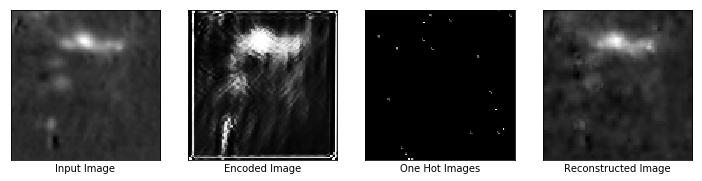

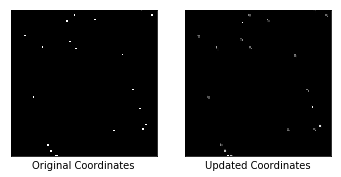

Epochs: 820, Loss: 0.001842847210355103
Similarity scores: [0.57303506 0.03834497 0.77482414 0.11280412 0.07428297 0.08597031
 0.02001201 0.03900935 0.03039101 0.03604542 0.0722649  0.03616539
 0.04239365 0.03105155 0.08911055 0.12522472 0.09907775 0.05683956
 0.91414356 0.02578184]
Updated Coordinates: [[[0.24716048 0.9272913 ]]]
Gradient min:-0.001154713099822402, max:0.0011276969453319907



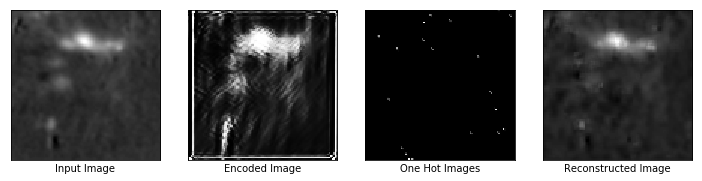

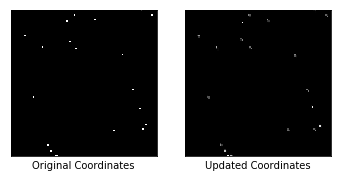

Epochs: 830, Loss: 0.0018474285025149584
Similarity scores: [0.65950507 0.04279578 0.7811333  0.10004839 0.08463611 0.06315853
 0.02416177 0.01190763 0.03003489 0.03932667 0.07360034 0.02087351
 0.04825951 0.02358155 0.08220541 0.11412706 0.10809079 0.05793939
 0.869508   0.02181989]
Updated Coordinates: [[[0.24721798 0.9273634 ]]]
Gradient min:-0.0011071639601141214, max:0.00038371700793504715



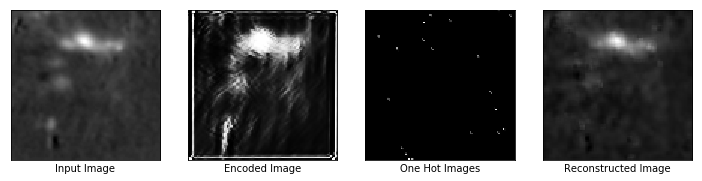

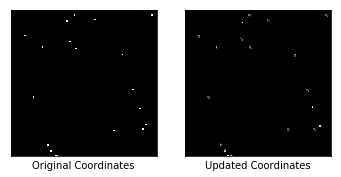

Epochs: 840, Loss: 0.002401015954092145
Similarity scores: [0.6434372  0.03320063 0.7618291  0.0838327  0.06845521 0.06464389
 0.02041453 0.021668   0.02857151 0.03069423 0.06518037 0.04998947
 0.03939877 0.02246321 0.07229307 0.0937278  0.08562417 0.06648405
 0.9115708  0.02218163]
Updated Coordinates: [[[0.24714918 0.92734414]]]
Gradient min:-0.0022651725448668003, max:0.0017479828093200922



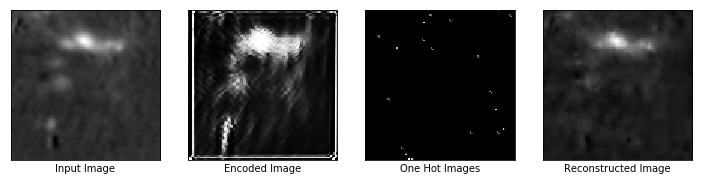

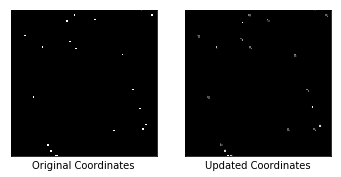

Epochs: 850, Loss: 0.001838746014982462
Similarity scores: [0.64523345 0.0369866  0.79209834 0.08046768 0.0704791  0.07647339
 0.0318742  0.03221567 0.02363058 0.0322691  0.06577327 0.04973423
 0.04066668 0.02123084 0.07564659 0.10957282 0.0946825  0.03986503
 0.87383074 0.02070642]
Updated Coordinates: [[[0.24718915 0.9272051 ]]]
Gradient min:-0.0011264793574810028, max:0.001040418166667223



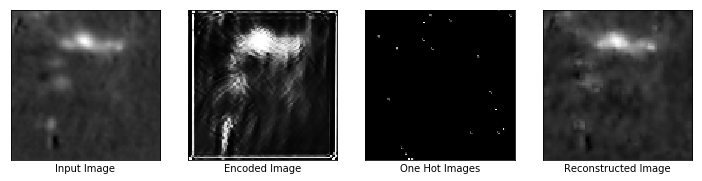

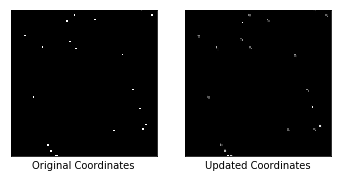

Epochs: 860, Loss: 0.0015131887048482895
Similarity scores: [0.6987173  0.04191208 0.79961765 0.10934852 0.07452697 0.10543786
 0.02143451 0.02248479 0.0332483  0.04230522 0.07191535 0.03595525
 0.04630482 0.02428446 0.08433183 0.09827308 0.10132551 0.06454886
 0.89800656 0.0233612 ]
Updated Coordinates: [[[0.24708076 0.92733467]]]
Gradient min:-0.00030283533851616085, max:0.00019497187167871743



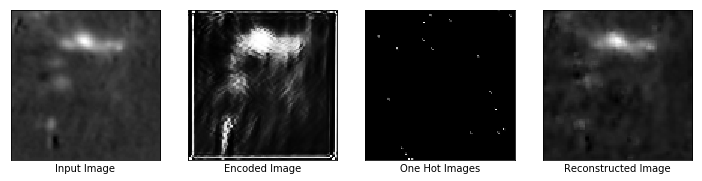

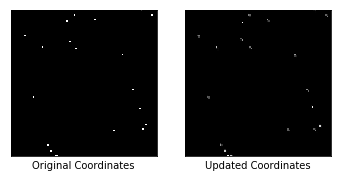

Epochs: 870, Loss: 0.0018611032282933593
Similarity scores: [0.6491964  0.03697595 0.7847477  0.08001064 0.0707465  0.05794711
 0.01540032 0.01778745 0.02597145 0.03497696 0.07645883 0.03442532
 0.0417579  0.01979608 0.06445778 0.09627396 0.13430765 0.02402479
 0.86294603 0.01567642]
Updated Coordinates: [[[0.24702966 0.92731446]]]
Gradient min:-0.00108865846414119, max:0.00015281079686246812



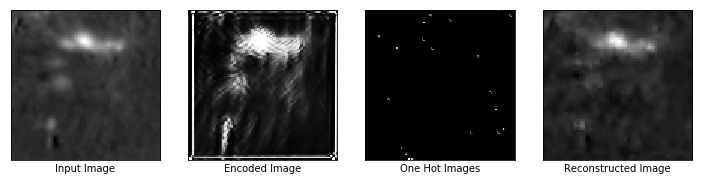

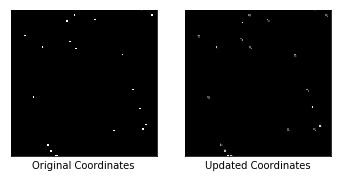

Epochs: 880, Loss: 0.00154532038141042
Similarity scores: [0.6401065  0.04164946 0.7562495  0.09850298 0.07623678 0.08026659
 0.01321021 0.02732558 0.0309475  0.03861437 0.07769289 0.04756399
 0.04645125 0.02028102 0.08056666 0.10283677 0.10228959 0.06784632
 0.9065723  0.0188651 ]
Updated Coordinates: [[[0.24697988 0.9273311 ]]]
Gradient min:-0.00047481374349445105, max:0.0006439864519052207



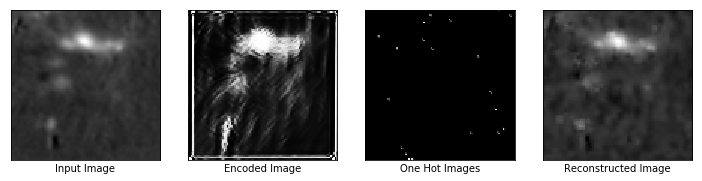

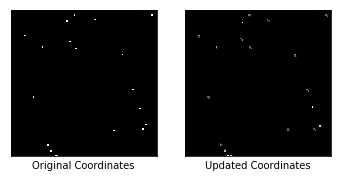

Epochs: 890, Loss: 0.0017696887953206897
Similarity scores: [0.75547284 0.03497053 0.77372557 0.10547511 0.07216508 0.04249216
 0.01999384 0.00910181 0.02291577 0.03636007 0.07211874 0.0544908
 0.04248583 0.01683822 0.06362081 0.08359154 0.17327881 0.02038176
 0.87850666 0.01776638]
Updated Coordinates: [[[0.24715616 0.9273332 ]]]
Gradient min:-0.0006430971552617848, max:6.944953202037141e-05



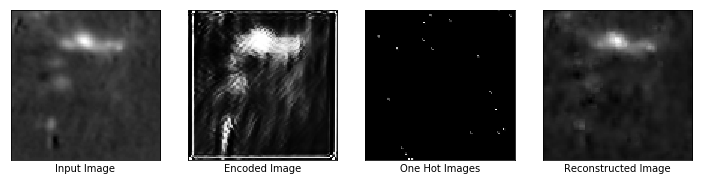

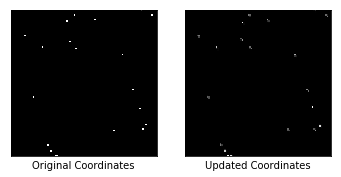

Epochs: 900, Loss: 0.0017839550273492932
Similarity scores: [0.6340386  0.04120379 0.8116672  0.11697213 0.08671886 0.06759395
 0.01694982 0.00690828 0.03032871 0.03843477 0.08365656 0.03034085
 0.04428009 0.02716445 0.08572791 0.09115566 0.14355889 0.0646932
 0.8678541  0.02329067]
Updated Coordinates: [[[0.24715129 0.92715317]]]
Gradient min:-0.0009453294333070517, max:0.0008222991600632668



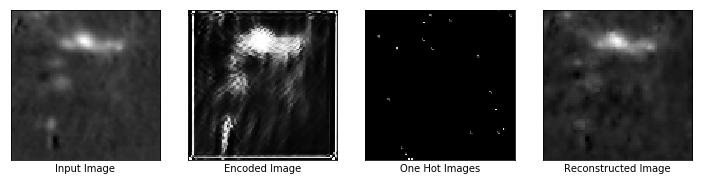

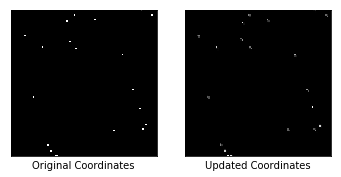

Epochs: 910, Loss: 0.0015691909939050674
Similarity scores: [0.6536861  0.03727539 0.7884521  0.09859286 0.06897637 0.06089902
 0.01862475 0.01830005 0.02883198 0.03352008 0.06550249 0.04929184
 0.04270477 0.02093207 0.07350323 0.09548237 0.08089086 0.05325247
 0.8458133  0.0211808 ]
Updated Coordinates: [[[0.24695937 0.92708564]]]
Gradient min:-0.000375174917280674, max:0.00043070889660157263



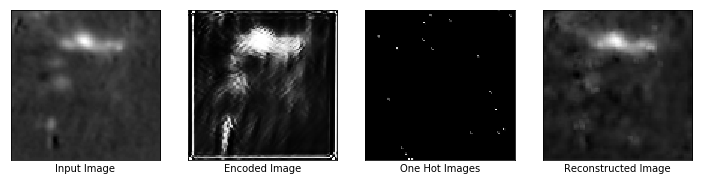

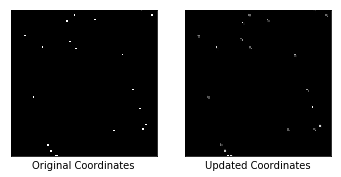

Epochs: 920, Loss: 0.001677613821811974
Similarity scores: [0.5878298  0.03807893 0.799484   0.09183044 0.07037798 0.0580858
 0.02721318 0.0160277  0.02545858 0.03480946 0.06505286 0.04590363
 0.04083395 0.01758504 0.0683737  0.09021642 0.13382617 0.02908264
 0.8123091  0.01844501]
Updated Coordinates: [[[0.24697326 0.9269695 ]]]
Gradient min:-0.0006889790529385209, max:0.0005475352518260479



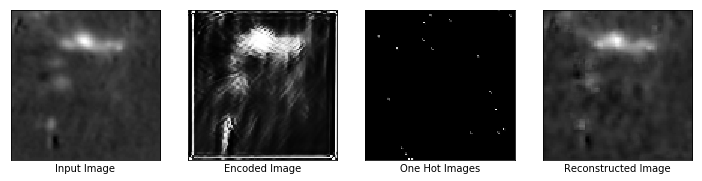

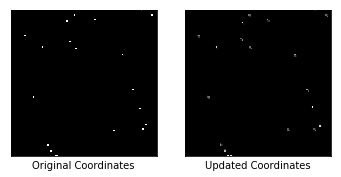

Epochs: 930, Loss: 0.002066731685772538
Similarity scores: [0.66790223 0.04024127 0.8540926  0.10299999 0.07592625 0.07803702
 0.0321408  0.0129064  0.03768962 0.03374011 0.06639134 0.02213604
 0.04579202 0.02527222 0.08957875 0.1192826  0.24453367 0.02465585
 0.8070304  0.02017045]
Updated Coordinates: [[[0.24680297 0.9270914 ]]]
Gradient min:-0.0010863475035876036, max:0.0002240425965283066



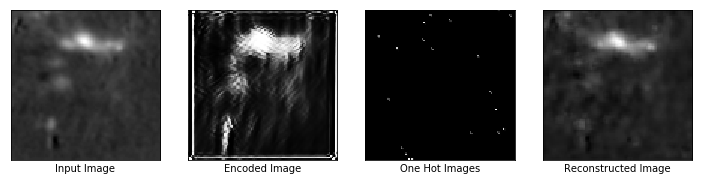

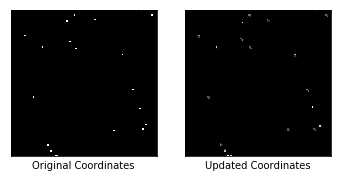

Epochs: 940, Loss: 0.0026318083982914686
Similarity scores: [0.6742711  0.03500824 0.8178426  0.07688751 0.07153584 0.04522818
 0.01935263 0.0107504  0.03545151 0.03095798 0.06407173 0.02651221
 0.03672628 0.02015589 0.07979857 0.07116427 0.08805241 0.05445067
 0.88351387 0.01458033]
Updated Coordinates: [[[0.24685536 0.9269452 ]]]
Gradient min:-0.0028655752539634705, max:0.0017528394237160683



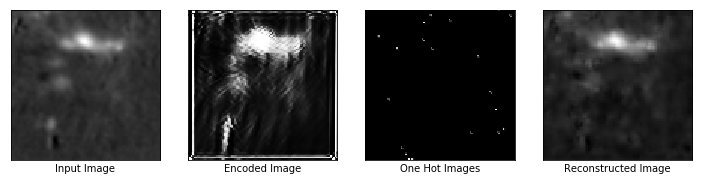

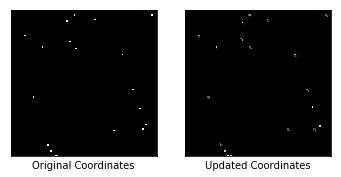

Epochs: 950, Loss: 0.0016699396073818207
Similarity scores: [0.59199816 0.03264332 0.8213957  0.08503329 0.06592355 0.08367227
 0.02728662 0.01068919 0.03893951 0.02678863 0.06235448 0.01381904
 0.03592309 0.02197558 0.07140405 0.0688087  0.16009197 0.02812396
 0.86557746 0.02060056]
Updated Coordinates: [[[0.24696831 0.9270529 ]]]
Gradient min:-0.00023006425180938095, max:0.00018021819414570928



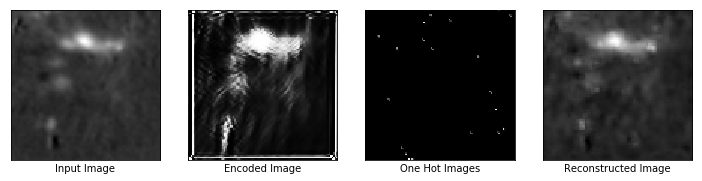

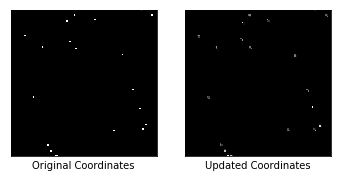

Epochs: 960, Loss: 0.001741131767630577
Similarity scores: [0.64532685 0.03131887 0.8409531  0.08813771 0.06013424 0.05471517
 0.01888739 0.01118218 0.02023104 0.02659748 0.0588049  0.02854619
 0.0361911  0.01764465 0.05973515 0.07941361 0.09292096 0.03387376
 0.9122239  0.01483789]
Updated Coordinates: [[[0.24704671 0.92706335]]]
Gradient min:-0.0005795862525701523, max:0.0009598456090316176



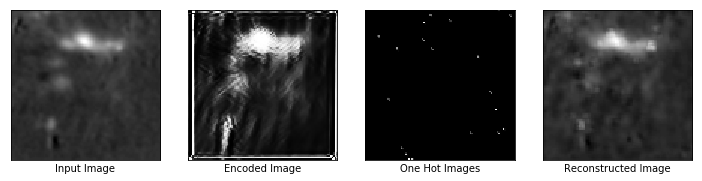

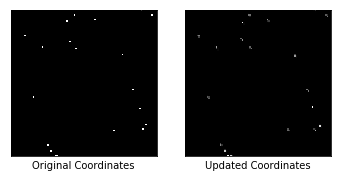

Epochs: 970, Loss: 0.0016877708258107305
Similarity scores: [0.65608466 0.0422047  0.8527035  0.14849065 0.07665391 0.06561644
 0.03261927 0.00810414 0.02955706 0.03466573 0.07679208 0.01340478
 0.04890225 0.02929121 0.06866305 0.10865902 0.07046974 0.02264276
 0.85926706 0.02614902]
Updated Coordinates: [[[0.24701624 0.9271705 ]]]
Gradient min:-0.0020995158702135086, max:0.002632046351209283



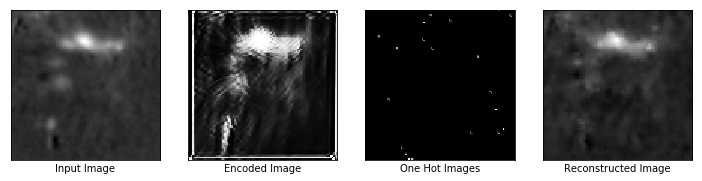

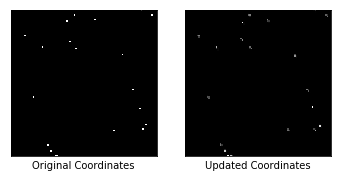

Epochs: 980, Loss: 0.0015550840180367231
Similarity scores: [0.6299268  0.03766084 0.8277708  0.11466011 0.07135833 0.06454971
 0.05112135 0.00482095 0.03665165 0.03361371 0.0705488  0.0258948
 0.04359875 0.02454404 0.06972616 0.1124438  0.07657117 0.04171693
 0.85905856 0.02624338]
Updated Coordinates: [[[0.24700725 0.92697746]]]
Gradient min:-0.00032375112641602755, max:0.00042751539149321616



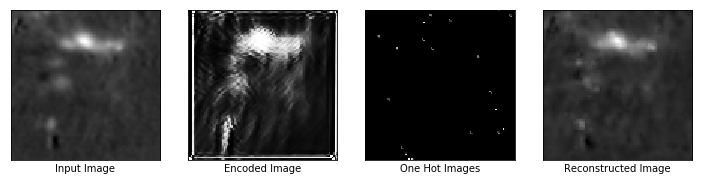

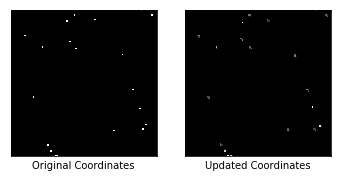

Epochs: 990, Loss: 0.0015695234760642052
Similarity scores: [0.6956004  0.04565497 0.79119444 0.11349266 0.08284765 0.08502439
 0.04065382 0.01703592 0.03766906 0.03984665 0.07963658 0.02423502
 0.05264834 0.02827094 0.08071213 0.11788668 0.1361547  0.04349503
 0.88294923 0.02204314]
Updated Coordinates: [[[0.24707898 0.92701167]]]
Gradient min:-0.0013687583850696683, max:0.001262366771697998



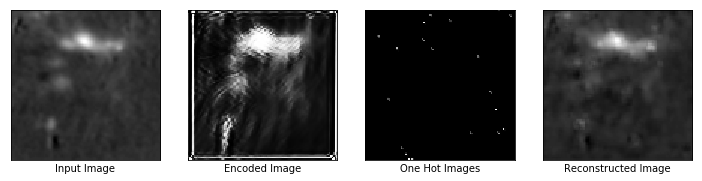

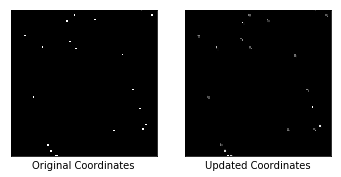

Epochs: 1000, Loss: 0.001561913639307022
Similarity scores: [0.6172992  0.04498919 0.7859736  0.10571641 0.08849785 0.0836068
 0.03714217 0.01497366 0.03978028 0.04136399 0.07678325 0.0284369
 0.05101602 0.03084082 0.08326385 0.14076863 0.14185598 0.04746101
 0.8689108  0.02729546]
Updated Coordinates: [[[0.24704197 0.9270548 ]]]
Gradient min:-0.0008403791580349207, max:0.0012201316421851516



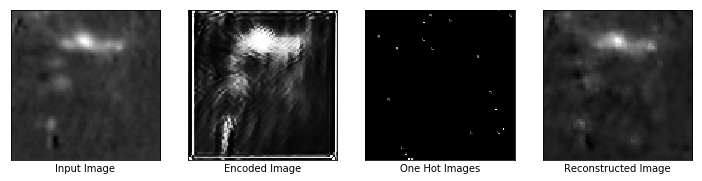

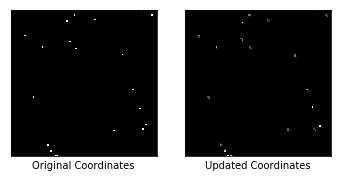

Epochs: 1010, Loss: 0.0017624570755288005
Similarity scores: [0.6344022  0.04416794 0.7876396  0.12124838 0.08410995 0.10996861
 0.02372958 0.01869686 0.04194025 0.04059533 0.07659852 0.01331319
 0.05123597 0.0317033  0.08656184 0.11277411 0.1503689  0.03836566
 0.84383106 0.02909116]
Updated Coordinates: [[[0.24710296 0.92720157]]]
Gradient min:-0.0026251126546412706, max:0.002763107419013977



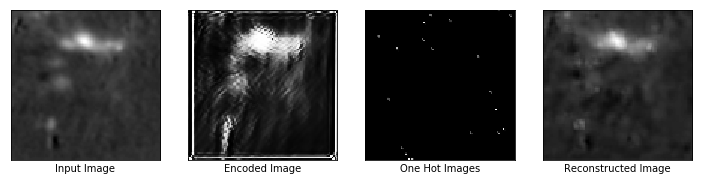

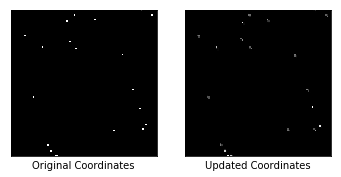

Epochs: 1020, Loss: 0.001650091726332903
Similarity scores: [0.6164205  0.04427865 0.77935624 0.0979396  0.09067901 0.09770299
 0.02436438 0.00966417 0.04838948 0.03993844 0.07607776 0.01226945
 0.04902835 0.03535925 0.08629005 0.10212171 0.1160855  0.04417331
 0.84353906 0.02525168]
Updated Coordinates: [[[0.24714345 0.9271737 ]]]
Gradient min:-0.000965234765317291, max:0.001202813582494855



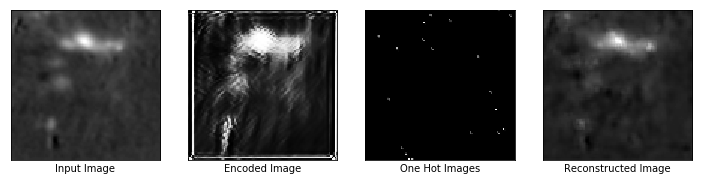

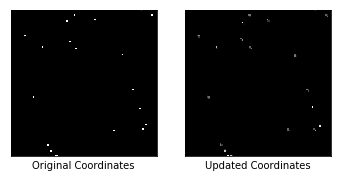

Epochs: 1030, Loss: 0.0016842718468979
Similarity scores: [0.6146245  0.05110945 0.78080285 0.09780417 0.09950797 0.09229776
 0.04024633 0.01887668 0.05028944 0.04593342 0.08194719 0.03105568
 0.05614499 0.03759081 0.08994012 0.11008921 0.13277785 0.04438943
 0.8939235  0.02945973]
Updated Coordinates: [[[0.24708934 0.92710227]]]
Gradient min:-0.0010076169855892658, max:0.0005761240608990192



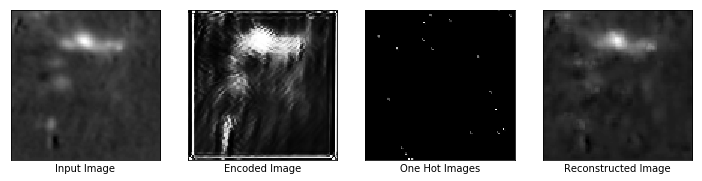

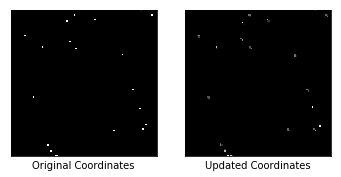

Epochs: 1040, Loss: 0.0016268470790237188
Similarity scores: [0.6958914  0.04884902 0.7592349  0.10870035 0.09154147 0.09904607
 0.02585881 0.01452382 0.0438085  0.04536171 0.09185202 0.02498341
 0.0526602  0.02716334 0.08541498 0.06586223 0.15203166 0.03250236
 0.8472641  0.02177298]
Updated Coordinates: [[[0.24687319 0.92697257]]]
Gradient min:-0.001243799808435142, max:0.0007248029578477144



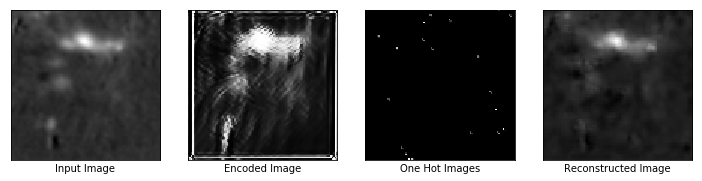

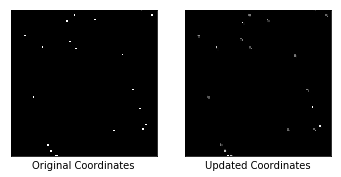

Epochs: 1050, Loss: 0.0016633693594485521
Similarity scores: [0.57589436 0.04833227 0.7723476  0.11480546 0.10537683 0.10013308
 0.03072089 0.011574   0.05258084 0.04347136 0.07769712 0.01473838
 0.05157193 0.04537581 0.10255849 0.09291512 0.18370348 0.03377931
 0.8140154  0.03377222]
Updated Coordinates: [[[0.2468965 0.9269512]]]
Gradient min:-0.0006598409381695092, max:0.00039228759123943746



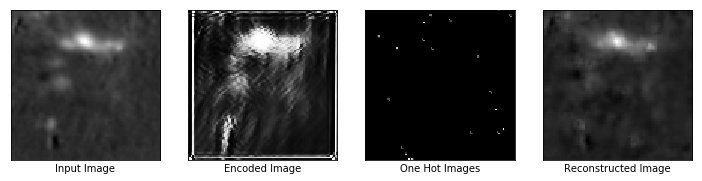

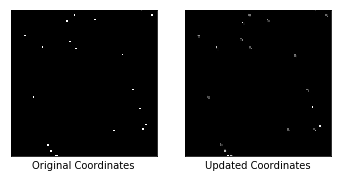

Epochs: 1060, Loss: 0.0016424987697973847
Similarity scores: [0.6217172  0.06539369 0.7558026  0.13003561 0.1072769  0.09808384
 0.05540542 0.00634774 0.05497949 0.05693681 0.09825899 0.02368881
 0.06953089 0.03660027 0.07296851 0.09308484 0.16958165 0.02939823
 0.79551256 0.0325848 ]
Updated Coordinates: [[[0.24688135 0.9267471 ]]]
Gradient min:-0.0008845374104566872, max:0.00048395374324172735



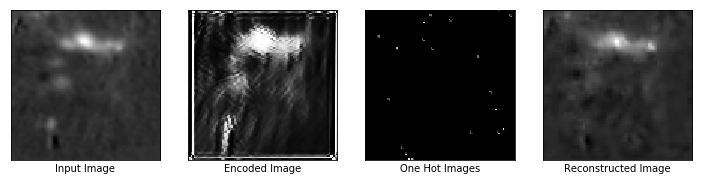

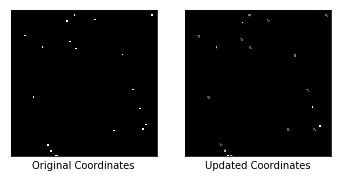

Epochs: 1070, Loss: 0.0018141799373552203
Similarity scores: [0.62684965 0.05364357 0.75759643 0.12960106 0.0946174  0.06049187
 0.07007907 0.01988493 0.0400703  0.04890468 0.08798996 0.0226113
 0.06306438 0.03973662 0.07243706 0.11039516 0.1816349  0.01215077
 0.82593465 0.02417965]
Updated Coordinates: [[[0.24664328 0.926775  ]]]
Gradient min:-0.00044384936336427927, max:0.00040009760414250195



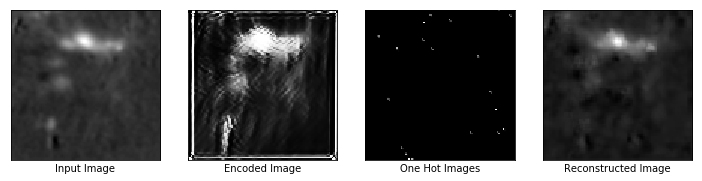

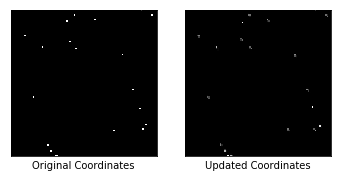

Epochs: 1080, Loss: 0.0018079262226819992
Similarity scores: [0.6382529  0.04297868 0.74809253 0.10004795 0.09068406 0.06739792
 0.04337071 0.01321489 0.0389901  0.0398212  0.07314856 0.02793433
 0.04932958 0.02203831 0.05853807 0.11331244 0.1510585  0.00664257
 0.8165335  0.0197766 ]
Updated Coordinates: [[[0.2464435  0.92662966]]]
Gradient min:-0.0009092524414882064, max:0.0010719153797253966



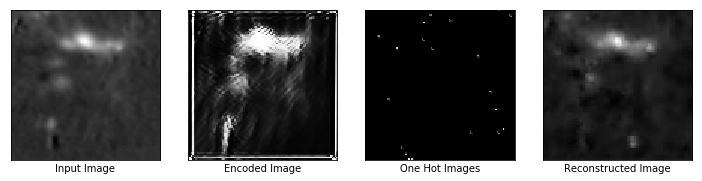

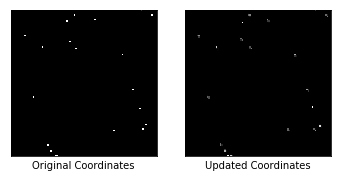

Epochs: 1090, Loss: 0.0019780390430241823
Similarity scores: [0.49182317 0.02662387 0.80913264 0.1044897  0.06627596 0.0674561
 0.03236462 0.00941101 0.03003697 0.02308896 0.0493767  0.01127438
 0.03253746 0.02056435 0.06459471 0.08488708 0.17148033 0.00916437
 0.780156   0.02275169]
Updated Coordinates: [[[0.24640524 0.9265168 ]]]
Gradient min:-0.0034756867680698633, max:0.005098648834973574



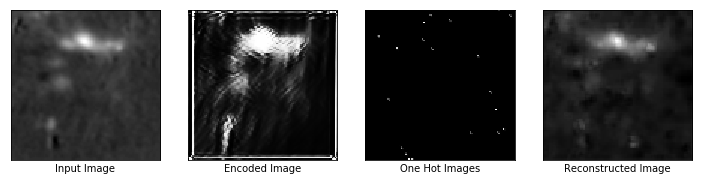

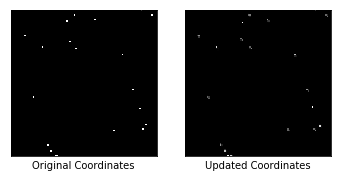

Epochs: 1100, Loss: 0.0026676924899220467
Similarity scores: [0.5739544  0.01601292 0.78425264 0.08834816 0.04800507 0.06191669
 0.02352231 0.00677114 0.0249276  0.01417514 0.02939551 0.02869712
 0.02188618 0.01928079 0.04027345 0.05250529 0.11853299 0.00322574
 0.90673447 0.01751192]
Updated Coordinates: [[[0.2462731  0.92671424]]]
Gradient min:-0.004514053463935852, max:0.005831068381667137



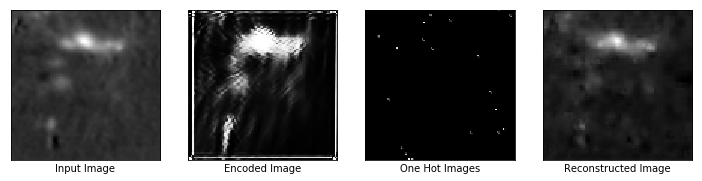

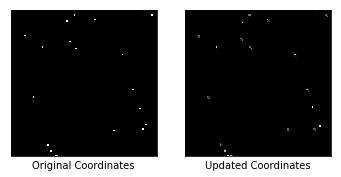

Epochs: 1110, Loss: 0.0031628203578293324
Similarity scores: [0.6220033  0.00836487 0.85099125 0.0724326  0.02567574 0.04568696
 0.0190213  0.00385422 0.02022073 0.00646078 0.02000492 0.01854198
 0.01242173 0.01999564 0.05871344 0.049406   0.15260568 0.00489063
 0.894787   0.01804315]
Updated Coordinates: [[[0.24647357 0.9267567 ]]]
Gradient min:-0.0029495246708393097, max:0.004108631517738104



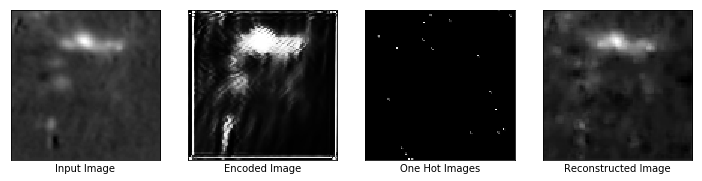

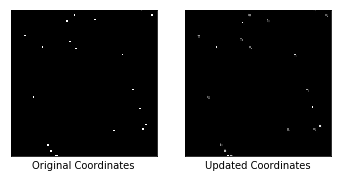

Epochs: 1120, Loss: 0.00245014694519341
Similarity scores: [0.6361283  0.00841339 0.88053495 0.07754135 0.02826853 0.06048665
 0.01431577 0.00265376 0.02007231 0.00679693 0.02231403 0.00963044
 0.01261379 0.02109725 0.0498501  0.04999439 0.12636405 0.0057847
 0.87974435 0.01906183]
Updated Coordinates: [[[0.24655406 0.926891  ]]]
Gradient min:-0.003220493672415614, max:0.0042843446135520935



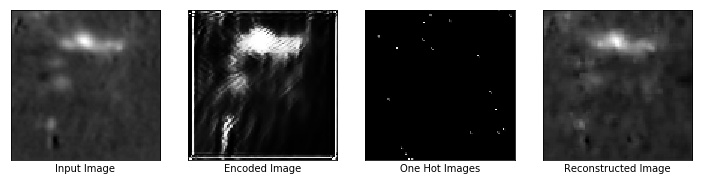

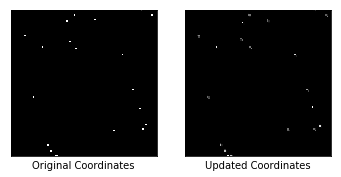

Epochs: 1130, Loss: 0.0018400216940790415
Similarity scores: [0.7119139  0.00772713 0.879866   0.09611452 0.02381114 0.05073971
 0.01338935 0.00275514 0.01822526 0.00593951 0.01852094 0.01866462
 0.01192807 0.0205327  0.06392531 0.05439557 0.2239704  0.01645478
 0.92934406 0.02208633]
Updated Coordinates: [[[0.24638098 0.9270791 ]]]
Gradient min:-0.00020543519349303097, max:0.001039029797539115



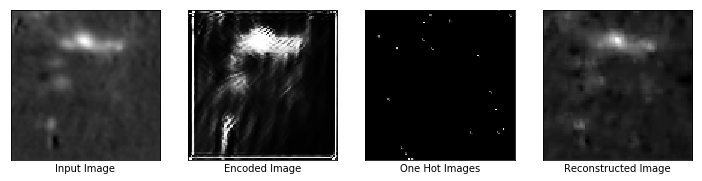

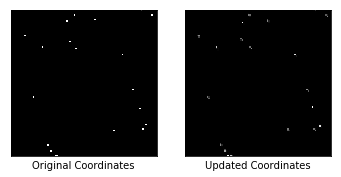

Epochs: 1140, Loss: 0.0017177545232698321
Similarity scores: [0.61267745 0.00773973 0.77118903 0.10304979 0.02227534 0.05040235
 0.00974316 0.00134345 0.01292217 0.00679214 0.02012242 0.01298497
 0.01363313 0.01617216 0.04370862 0.0323972  0.21995747 0.01274983
 0.8687917  0.01933174]
Updated Coordinates: [[[0.24663766 0.9269018 ]]]
Gradient min:-0.0008374895551241934, max:0.0010173037881031632



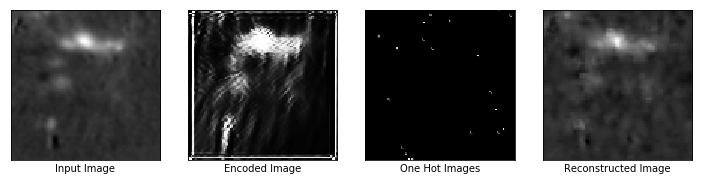

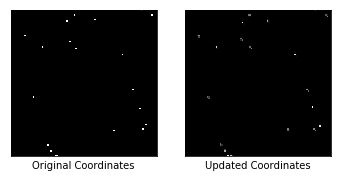

Epochs: 1150, Loss: 0.0014946798328310251
Similarity scores: [0.6775716  0.01334959 0.75769305 0.11648038 0.03834734 0.06194421
 0.01503826 0.00122136 0.01941201 0.01059452 0.03466866 0.02085487
 0.0187123  0.03310391 0.05052235 0.05290489 0.2518483  0.0059445
 0.8112187  0.02023604]
Updated Coordinates: [[[0.24684885 0.92677784]]]
Gradient min:-0.00047093164175748825, max:0.0007173445774242282



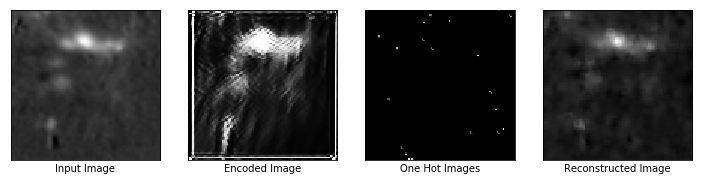

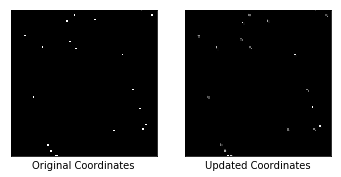

Epochs: 1160, Loss: 0.0016157528152689338
Similarity scores: [0.6049985  0.02248439 0.75913143 0.12920387 0.06187752 0.06635547
 0.02166388 0.00482072 0.03225993 0.01907713 0.04681053 0.01924815
 0.03038196 0.04452957 0.09753895 0.06715502 0.22254533 0.01811784
 0.8515712  0.0314006 ]
Updated Coordinates: [[[0.24674591 0.92686963]]]
Gradient min:-0.0007653867360204458, max:0.0009359513060189784



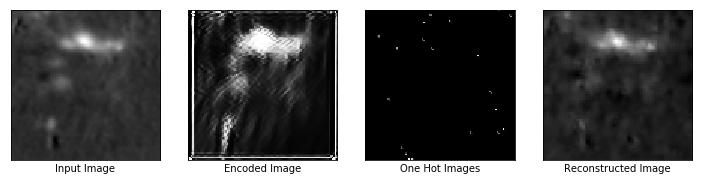

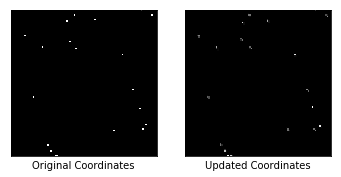

Epochs: 1170, Loss: 0.0013554815668612719
Similarity scores: [0.5668136  0.0260643  0.78939474 0.11289095 0.06281439 0.07349604
 0.02561408 0.00732407 0.04083474 0.02214571 0.05208553 0.02639608
 0.0339078  0.04240815 0.1060044  0.11776582 0.1920315  0.01740465
 0.8083621  0.03063162]
Updated Coordinates: [[[0.24665786 0.92673224]]]
Gradient min:-0.0006840151036158204, max:0.0009505671332590282



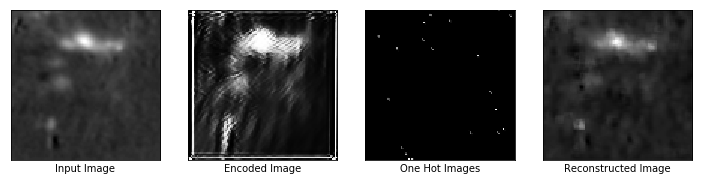

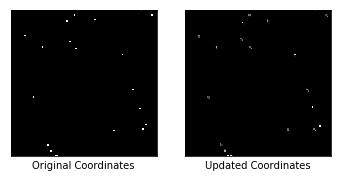

Epochs: 1180, Loss: 0.001606522942893207
Similarity scores: [0.6201525  0.03073622 0.76540005 0.14175661 0.06442782 0.0622496
 0.04387971 0.00277591 0.03202597 0.02586504 0.06032657 0.03118751
 0.0427119  0.05040076 0.07628014 0.08533915 0.24741098 0.0154198
 0.83874184 0.03128181]
Updated Coordinates: [[[0.24680771 0.9267346 ]]]
Gradient min:-0.0012449405621737242, max:0.001438253209926188



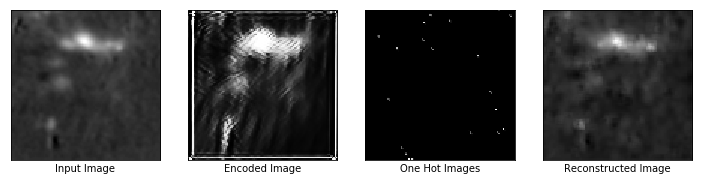

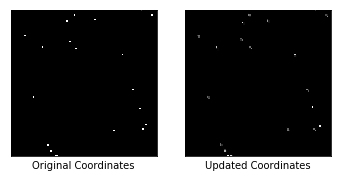

Epochs: 1190, Loss: 0.0015298988437280059
Similarity scores: [0.5850898  0.02843206 0.7855646  0.12451656 0.06385729 0.08642958
 0.02557683 0.00537051 0.04608916 0.02391507 0.05709454 0.02214616
 0.03706652 0.04453281 0.10172769 0.10398578 0.1437405  0.01167569
 0.8986887  0.03592343]
Updated Coordinates: [[[0.24673928 0.9267351 ]]]
Gradient min:-0.0008989734924398363, max:0.0009148308890871704



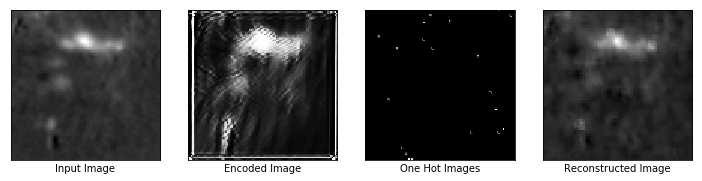

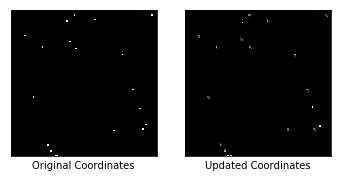

Epochs: 1200, Loss: 0.0016788137145340443
Similarity scores: [0.61586493 0.04235053 0.71467906 0.13308981 0.08217888 0.08492936
 0.05096913 0.00364118 0.05730604 0.03338907 0.07198966 0.03231118
 0.05174918 0.05760593 0.10220134 0.15273127 0.20021546 0.01000005
 0.8698849  0.03965398]
Updated Coordinates: [[[0.24654128 0.9267646 ]]]
Gradient min:-0.001088351709768176, max:0.000656653312034905



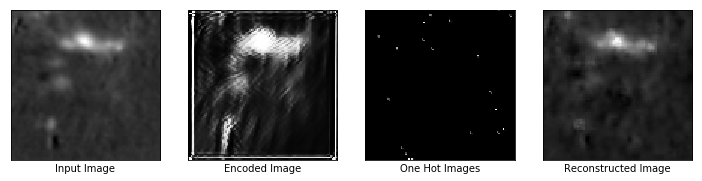

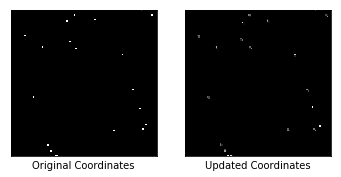

Epochs: 1210, Loss: 0.001682235742919147
Similarity scores: [0.6349599  0.03045776 0.79258364 0.12507595 0.06391568 0.06953543
 0.03701612 0.00284152 0.03351888 0.02504927 0.05887276 0.02973603
 0.04059556 0.03552143 0.1236309  0.12734085 0.13643815 0.00546466
 0.8755834  0.0347655 ]
Updated Coordinates: [[[0.24653904 0.926657  ]]]
Gradient min:-0.0016725565074011683, max:0.0013898423640057445



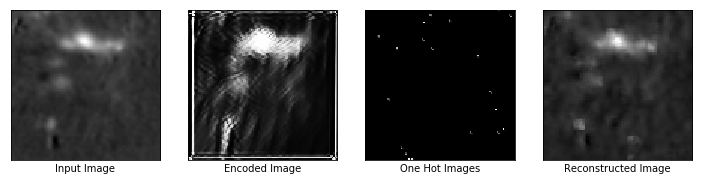

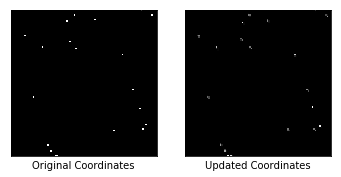

Epochs: 1220, Loss: 0.0018686914118006825
Similarity scores: [0.7299846  0.02849885 0.7208374  0.11781903 0.05575203 0.06235708
 0.03089749 0.0052859  0.04116181 0.02281551 0.04989994 0.02924176
 0.03818743 0.05303498 0.09286088 0.10961675 0.15227139 0.00848684
 0.92302495 0.04078079]
Updated Coordinates: [[[0.24645123 0.92691517]]]
Gradient min:-0.001805101172067225, max:0.0017544947331771255



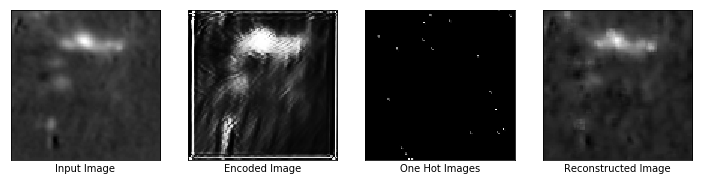

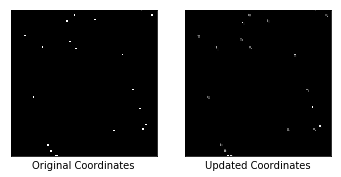

Epochs: 1230, Loss: 0.0017822308000177145
Similarity scores: [0.6697131  0.03937609 0.7804384  0.12467993 0.07308977 0.08264679
 0.0437619  0.00758593 0.05102818 0.02926422 0.0654052  0.03482886
 0.0483674  0.04864033 0.09685631 0.11366844 0.19909784 0.0085329
 0.8754178  0.03494964]
Updated Coordinates: [[[0.24649167 0.9268476 ]]]
Gradient min:-0.0016678505344316363, max:0.0013090568827465177



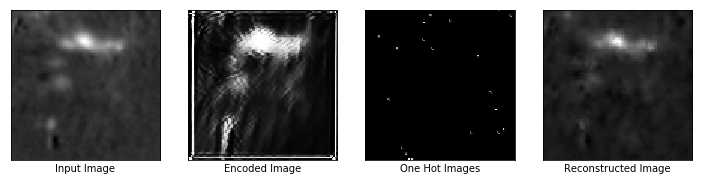

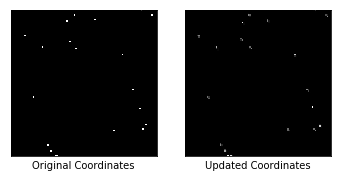

Epochs: 1240, Loss: 0.0020748230163007975
Similarity scores: [0.64996606 0.02730159 0.7796318  0.10432573 0.05597047 0.08460593
 0.02285558 0.00636796 0.03324454 0.02239555 0.05165391 0.02301986
 0.03692052 0.02644644 0.0641844  0.09493683 0.1779305  0.01345309
 0.8512007  0.02731459]
Updated Coordinates: [[[0.24654123 0.9267736 ]]]
Gradient min:-0.0015416605165228248, max:0.0012827494647353888



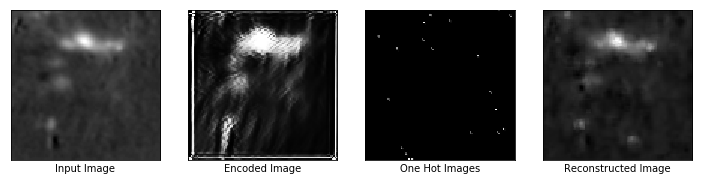

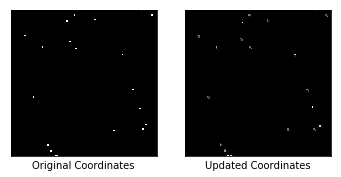

Epochs: 1250, Loss: 0.001827927422709763
Similarity scores: [0.64014447 0.02209009 0.795426   0.11488277 0.04553629 0.06566817
 0.0258853  0.00221197 0.02286776 0.0171716  0.04714317 0.02073712
 0.02989201 0.02426527 0.05649801 0.07154717 0.19538257 0.00434068
 0.8716786  0.01934744]
Updated Coordinates: [[[0.24656428 0.9268917 ]]]
Gradient min:-0.0013557521160691977, max:0.0012258487986400723



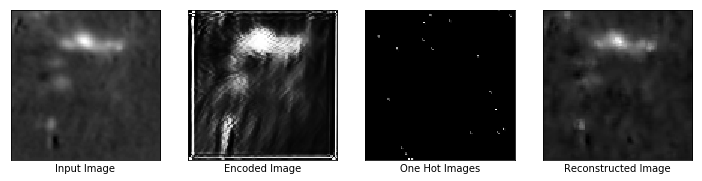

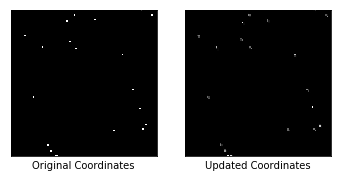

Epochs: 1260, Loss: 0.0013755559921264648
Similarity scores: [0.6980294  0.03759807 0.7888394  0.14076456 0.0693609  0.08543693
 0.03135987 0.00396806 0.03436135 0.03138925 0.06943921 0.03628014
 0.04796682 0.04465558 0.07947636 0.09053542 0.22596928 0.01301314
 0.8339144  0.03515432]
Updated Coordinates: [[[0.24658626 0.9267515 ]]]
Gradient min:-0.0005349559360183775, max:0.0005423753755167127



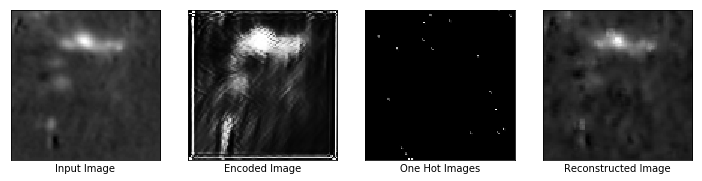

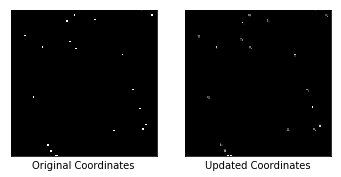

Epochs: 1270, Loss: 0.0014127327594906092
Similarity scores: [0.7143441  0.03710296 0.756102   0.12268745 0.07005457 0.06573939
 0.05194312 0.00508552 0.0322393  0.03139091 0.06960715 0.04837568
 0.0451124  0.03759255 0.075462   0.09575506 0.17751537 0.00448087
 0.79951    0.03133804]
Updated Coordinates: [[[0.246471   0.92689383]]]
Gradient min:-0.0008207610226236284, max:0.000990749802440405



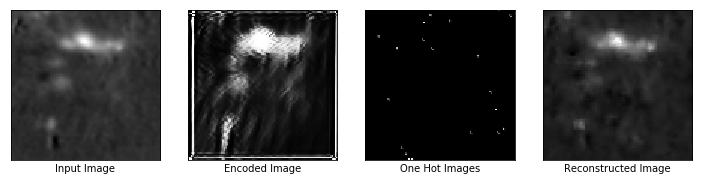

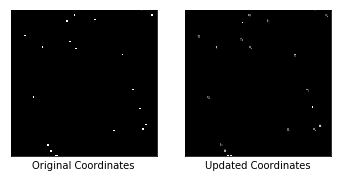

Epochs: 1280, Loss: 0.0021573922131210566
Similarity scores: [0.65153795 0.03087268 0.80550504 0.10472658 0.0583253  0.06403841
 0.02365399 0.00520842 0.03340301 0.02508954 0.05552814 0.02569222
 0.03491715 0.02573976 0.06806591 0.11358549 0.1766433  0.00737709
 0.8985904  0.0234056 ]
Updated Coordinates: [[[0.24662651 0.92667204]]]
Gradient min:-0.0022063625510782003, max:0.0015645603416487575



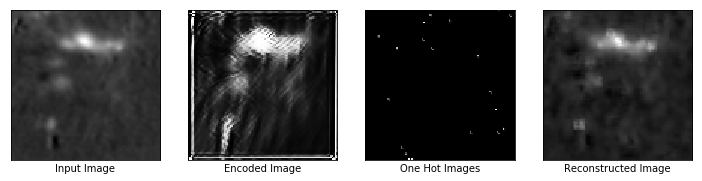

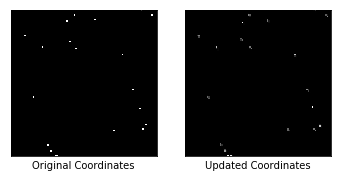

Epochs: 1290, Loss: 0.001616919762454927
Similarity scores: [0.560453   0.0410595  0.7889745  0.12698156 0.07450941 0.06058362
 0.04629464 0.00752745 0.04540379 0.03276012 0.07495134 0.02632995
 0.04684502 0.03110957 0.08233035 0.18080077 0.2577734  0.01217753
 0.8553517  0.03394013]
Updated Coordinates: [[[0.24676877 0.9266796 ]]]
Gradient min:-0.0006093858974054456, max:0.0011149774072691798



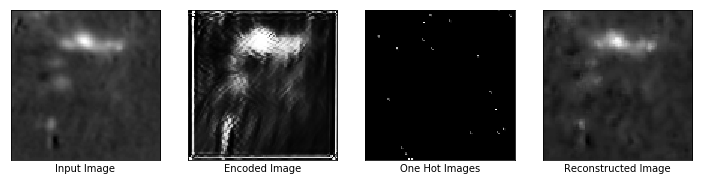

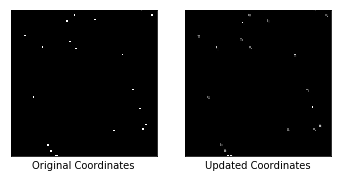

Epochs: 1300, Loss: 0.0013294086093083024
Similarity scores: [0.6801744  0.03908576 0.773459   0.10928804 0.07185164 0.07076517
 0.05263606 0.0102081  0.0346066  0.03154695 0.06991927 0.03516029
 0.04229565 0.03567858 0.06737807 0.12343541 0.20458901 0.00852901
 0.8733927  0.02783533]
Updated Coordinates: [[[0.24680512 0.92679787]]]
Gradient min:-0.0006825830205343664, max:0.00026665814220905304



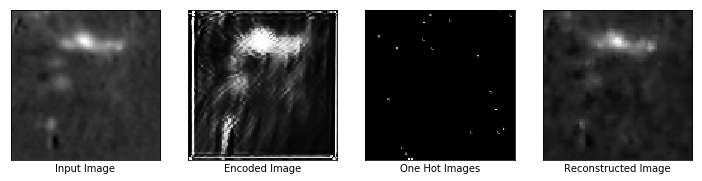

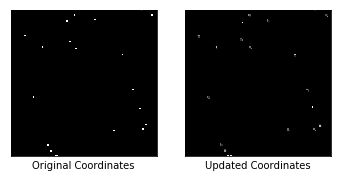

Epochs: 1310, Loss: 0.0016368133947253227
Similarity scores: [0.61872846 0.03474941 0.7798961  0.11511596 0.07148436 0.07461975
 0.03583328 0.00559156 0.045084   0.02708363 0.06485903 0.03624074
 0.04305468 0.04292466 0.08610681 0.11085677 0.2290499  0.00978041
 0.85776436 0.03778028]
Updated Coordinates: [[[0.246825   0.92675054]]]
Gradient min:-0.0019437719602137804, max:0.0021230224519968033



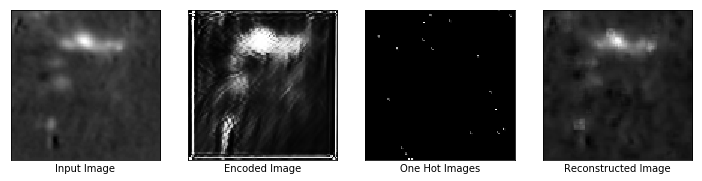

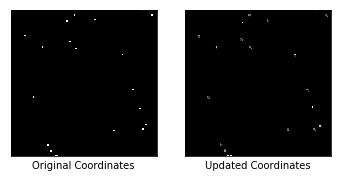

Epochs: 1320, Loss: 0.0013385402271524072
Similarity scores: [0.65736985 0.03458617 0.735115   0.09203743 0.07397543 0.07129455
 0.0325914  0.00782053 0.04100715 0.02699639 0.06545524 0.03096644
 0.04054185 0.03306175 0.08486088 0.12968437 0.191004   0.01043154
 0.8874764  0.02957842]
Updated Coordinates: [[[0.24660973 0.926716  ]]]
Gradient min:-0.0006997514283284545, max:0.0007021008059382439



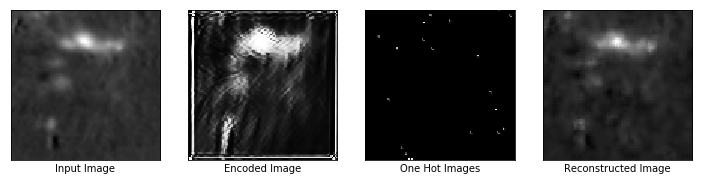

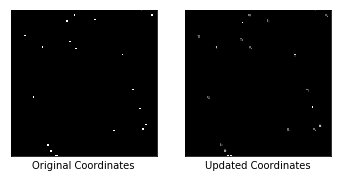

Epochs: 1330, Loss: 0.0017960863187909126
Similarity scores: [0.6393946  0.03604391 0.7374134  0.12276625 0.0707586  0.08085046
 0.03131918 0.00635248 0.0383864  0.03045861 0.07160616 0.01959687
 0.04288825 0.04419602 0.0946772  0.13272889 0.17399563 0.01121538
 0.91747415 0.03457982]
Updated Coordinates: [[[0.24658741 0.92671037]]]
Gradient min:-0.0020379291381686926, max:0.0019876069854944944



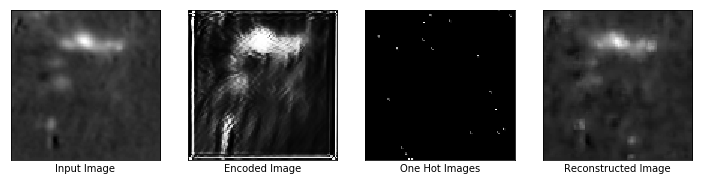

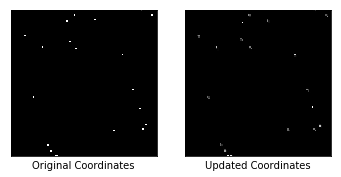

Epochs: 1340, Loss: 0.0017191326478496194
Similarity scores: [0.6573839  0.04294996 0.7761847  0.13134532 0.0757554  0.05889912
 0.03857695 0.00586179 0.03763817 0.03575394 0.07297675 0.02578672
 0.05080915 0.0396138  0.05767317 0.10932182 0.2030591  0.006567
 0.84234464 0.02981033]
Updated Coordinates: [[[0.246658  0.9266017]]]
Gradient min:-0.0010817553848028183, max:0.0008772260043770075



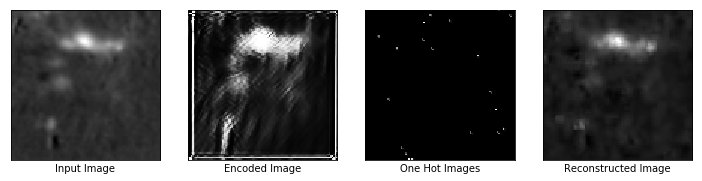

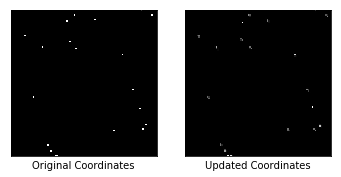

Epochs: 1350, Loss: 0.0019656571093946695
Similarity scores: [0.59281886 0.03451531 0.78350353 0.10054636 0.06539498 0.04796846
 0.03217867 0.00697514 0.03018655 0.03137988 0.06398201 0.03695093
 0.04232949 0.02236474 0.07636136 0.11578469 0.263547   0.00587428
 0.8356918  0.01984366]
Updated Coordinates: [[[0.24655485 0.92666054]]]
Gradient min:-0.0015784322749823332, max:0.0017426809063181281



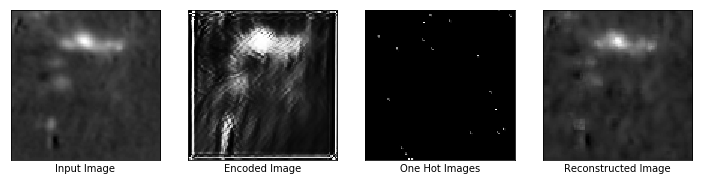

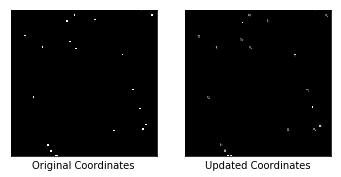

Epochs: 1360, Loss: 0.0014923401176929474
Similarity scores: [0.7196944  0.05347909 0.73269814 0.13431878 0.09592354 0.06877077
 0.0466346  0.01407872 0.05232764 0.04781504 0.09058767 0.02467523
 0.05798537 0.05929087 0.09599818 0.12249245 0.24822927 0.0135758
 0.8604994  0.03515652]
Updated Coordinates: [[[0.24647489 0.9267392 ]]]
Gradient min:-0.0007014222210273147, max:0.0002645032946020365



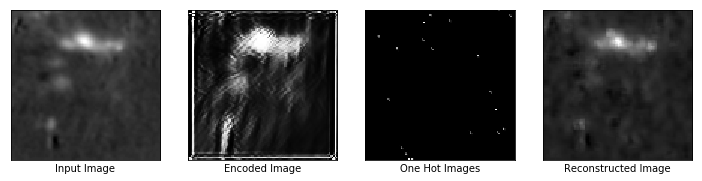

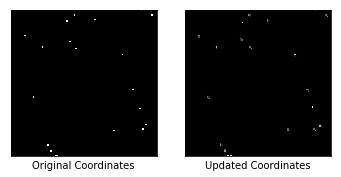

Epochs: 1370, Loss: 0.0014797182520851493
Similarity scores: [0.6763108  0.03921383 0.7161639  0.12531461 0.068956   0.04325195
 0.03444661 0.00544389 0.03308476 0.03215597 0.07811154 0.03178098
 0.04889595 0.03149757 0.0666564  0.11111075 0.2150544  0.01189536
 0.79019636 0.01933525]
Updated Coordinates: [[[0.24648592 0.92673075]]]
Gradient min:-0.0012062110472470522, max:0.0008356419857591391



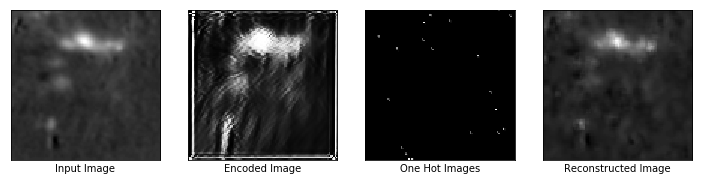

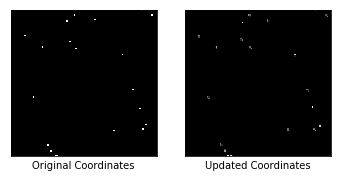

Epochs: 1380, Loss: 0.0015149310929700732
Similarity scores: [0.68535906 0.0504083  0.7289023  0.13816881 0.0848234  0.06797624
 0.04383502 0.01025882 0.04323257 0.04522693 0.08477741 0.05036796
 0.05749793 0.03414742 0.08207221 0.10706283 0.23527019 0.00978226
 0.836644   0.02515989]
Updated Coordinates: [[[0.24666387 0.9265518 ]]]
Gradient min:-0.0013878165045753121, max:0.0011408327845856547



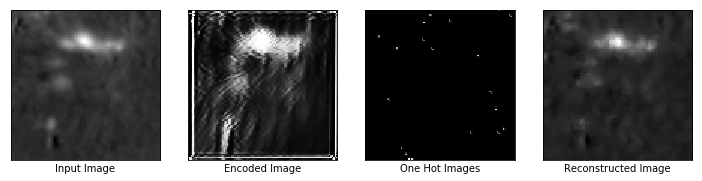

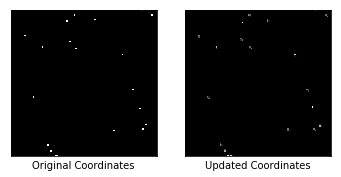

Epochs: 1390, Loss: 0.001354540465399623
Similarity scores: [0.715188   0.0471163  0.7108955  0.13095544 0.08299503 0.06889194
 0.03454326 0.00675441 0.03789379 0.03878683 0.08228755 0.03512936
 0.05640258 0.04076645 0.08346527 0.09314572 0.28397912 0.00541484
 0.8483329  0.02854403]
Updated Coordinates: [[[0.24645266 0.9267781 ]]]
Gradient min:-0.0003535012947395444, max:0.0001704283058643341



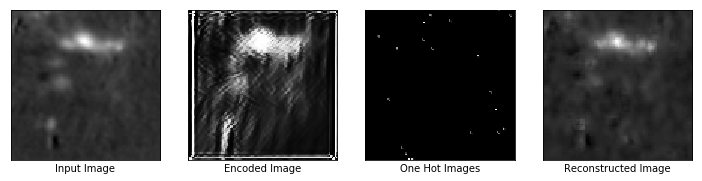

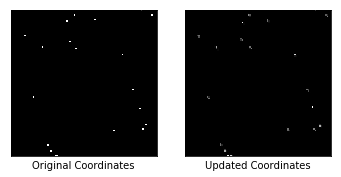

Epochs: 1400, Loss: 0.0014564237790182233
Similarity scores: [0.66725975 0.05072751 0.7042719  0.1560979  0.08774886 0.08416393
 0.02696691 0.01247248 0.05079777 0.04178983 0.08435149 0.03086131
 0.05449963 0.05032623 0.10237063 0.14011171 0.30188882 0.01732176
 0.8680103  0.04087243]
Updated Coordinates: [[[0.24653658 0.92661214]]]
Gradient min:-0.000601315638050437, max:0.000504363386426121



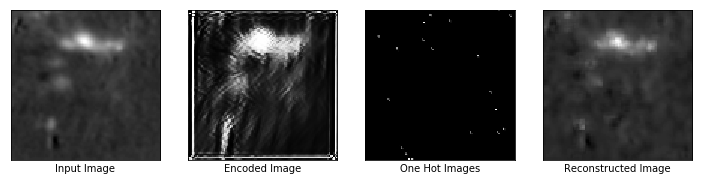

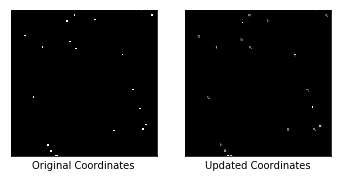

Epochs: 1410, Loss: 0.0014478927478194237
Similarity scores: [0.67561775 0.03976071 0.6832928  0.14024603 0.07886609 0.06632489
 0.03030831 0.01606539 0.04824481 0.03457766 0.08175871 0.02713455
 0.04573753 0.04395535 0.07245712 0.15860392 0.25404096 0.01494643
 0.8985908  0.02743961]
Updated Coordinates: [[[0.24646984 0.92664504]]]
Gradient min:-0.000836719642393291, max:0.000493345782160759



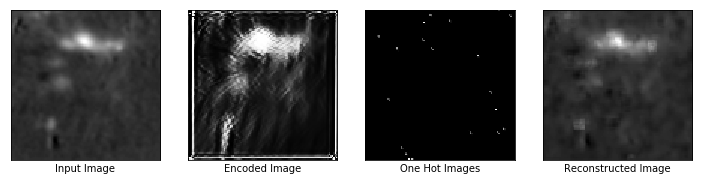

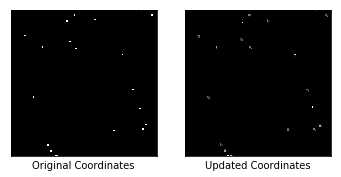

Epochs: 1420, Loss: 0.0015000501880422235
Similarity scores: [0.6584467  0.03611339 0.74225557 0.11521734 0.0710122  0.07291945
 0.03595085 0.0113236  0.04982982 0.02663069 0.0661187  0.03170445
 0.03903838 0.03478579 0.06136606 0.14514996 0.25634333 0.01190232
 0.9122896  0.02924167]
Updated Coordinates: [[[0.24655508 0.9265519 ]]]
Gradient min:-0.0006131217814981937, max:0.00025681802071630955



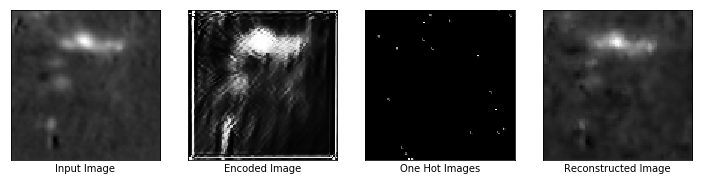

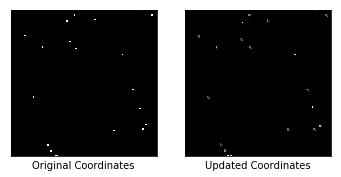

Epochs: 1430, Loss: 0.0016885786317288876
Similarity scores: [0.5486772  0.02509403 0.77738374 0.11491498 0.05452892 0.06217978
 0.02185355 0.00440212 0.03378463 0.01951808 0.04884671 0.03410653
 0.03217907 0.02329041 0.04932262 0.09525435 0.23792042 0.00339748
 0.8812955  0.0217442 ]
Updated Coordinates: [[[0.24666055 0.92668474]]]
Gradient min:-0.0023374389857053757, max:0.0025831751991063356



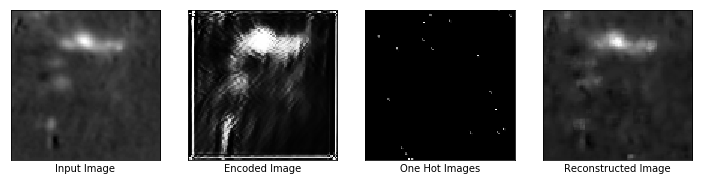

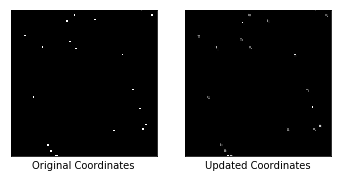

Epochs: 1440, Loss: 0.001622051582671702
Similarity scores: [0.66315955 0.01893604 0.7997881  0.09213492 0.045015   0.05625802
 0.01587614 0.00251765 0.02580476 0.01624323 0.03970463 0.02574276
 0.02399982 0.01989123 0.04393043 0.06866037 0.24558121 0.00546534
 0.873136   0.0204952 ]
Updated Coordinates: [[[0.24655376 0.92675906]]]
Gradient min:-0.0009196775499731302, max:0.00111522211227566



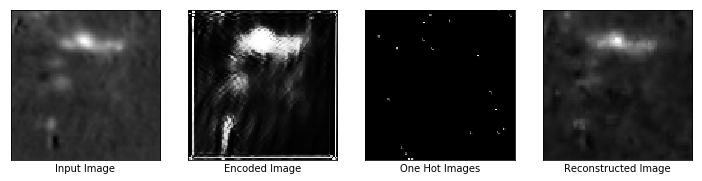

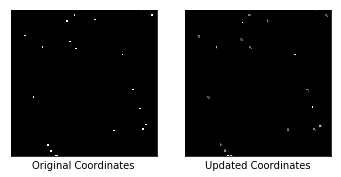

Epochs: 1450, Loss: 0.002065047388896346
Similarity scores: [0.58539724 0.0121647  0.8664351  0.0900892  0.0330728  0.04180953
 0.01721154 0.00222137 0.01404878 0.01047397 0.02590766 0.02431057
 0.01516515 0.00998116 0.03330423 0.06760572 0.22671136 0.00201243
 0.9038975  0.01011452]
Updated Coordinates: [[[0.2465735  0.92671424]]]
Gradient min:-0.0034509997349232435, max:0.0051591843366622925



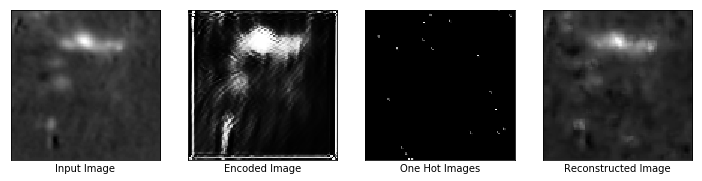

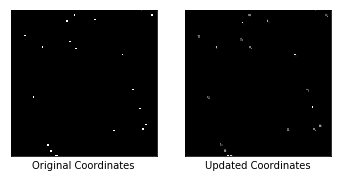

Epochs: 1460, Loss: 0.0014184735482558608
Similarity scores: [0.5947393  0.01380954 0.7961619  0.08624732 0.02993061 0.04857364
 0.01672067 0.00109138 0.02128544 0.0116578  0.02545902 0.0244717
 0.01836637 0.01472749 0.05380003 0.08368421 0.1459682  0.00526259
 0.9171513  0.01790567]
Updated Coordinates: [[[0.24660547 0.92647755]]]
Gradient min:-0.00023484035045839846, max:0.0004931694711558521



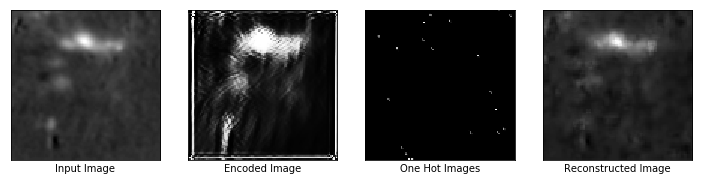

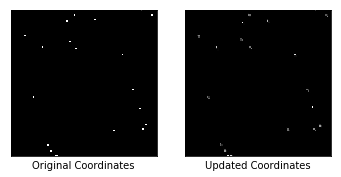

Epochs: 1470, Loss: 0.001566676190122962
Similarity scores: [0.6092379  0.01702119 0.80880225 0.08000813 0.03811436 0.0598917
 0.01906547 0.00219067 0.01990633 0.01380742 0.03474254 0.02121917
 0.02232162 0.03323396 0.05947455 0.07874526 0.25376037 0.00461979
 0.88406205 0.02304232]
Updated Coordinates: [[[0.24658003 0.9264848 ]]]
Gradient min:-0.0009656292968429625, max:0.0010013676946982741



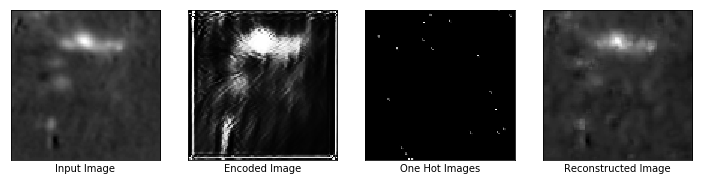

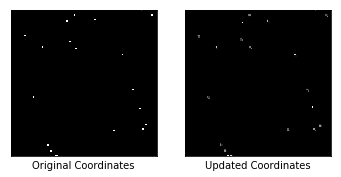

Epochs: 1480, Loss: 0.0015545214992016554
Similarity scores: [0.72937584 0.01931197 0.7311269  0.08886795 0.04162129 0.07383601
 0.0155167  0.00177811 0.03026574 0.01597687 0.04078494 0.01777528
 0.02348578 0.02435459 0.07025646 0.11647342 0.20438665 0.00712551
 0.96368694 0.01804176]
Updated Coordinates: [[[0.2464616 0.9266732]]]
Gradient min:-0.00037816623807884753, max:0.00039224038482643664



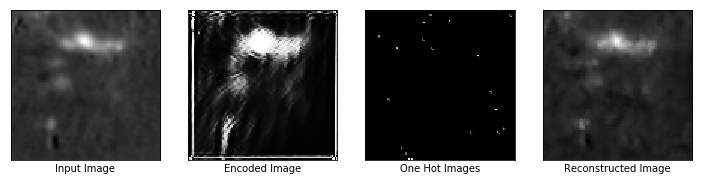

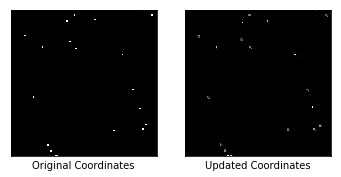

Epochs: 1490, Loss: 0.001633616629987955
Similarity scores: [0.5935896  0.00874084 0.76869625 0.07707298 0.02472104 0.05571855
 0.00696998 0.00238609 0.02078081 0.00841839 0.02267878 0.01515497
 0.01229515 0.02017753 0.06907357 0.07860641 0.19540912 0.00716458
 0.97364515 0.01607976]
Updated Coordinates: [[[0.24642663 0.9266497 ]]]
Gradient min:-0.0011977102840319276, max:0.0024185199290513992



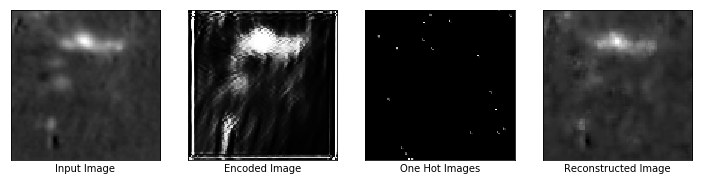

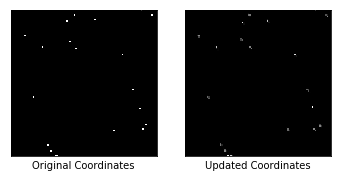

Epochs: 1500, Loss: 0.0018318117363378406
Similarity scores: [0.6974002  0.00772791 0.76381457 0.08541765 0.02153641 0.0475992
 0.01348141 0.00142981 0.01604605 0.00597522 0.02042133 0.02470248
 0.01286907 0.02198824 0.06011864 0.05905066 0.2146452  0.00134143
 0.9241238  0.0139127 ]
Updated Coordinates: [[[0.2464794  0.92660767]]]
Gradient min:-0.0005160676082596183, max:0.0008098256657831371



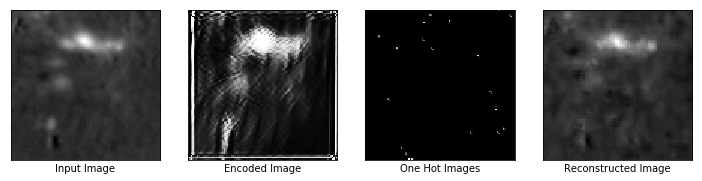

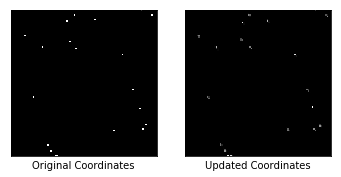

Epochs: 1510, Loss: 0.0013946781400591135
Similarity scores: [0.6091879  0.0263753  0.6865961  0.10601854 0.06135552 0.08353002
 0.03723327 0.00302584 0.04734064 0.01958004 0.04892161 0.02670819
 0.03391527 0.04423235 0.08670517 0.11738634 0.18252942 0.00394322
 0.8977066  0.02975524]
Updated Coordinates: [[[0.24638833 0.92650837]]]
Gradient min:-0.0005773219745606184, max:0.0005976931424811482



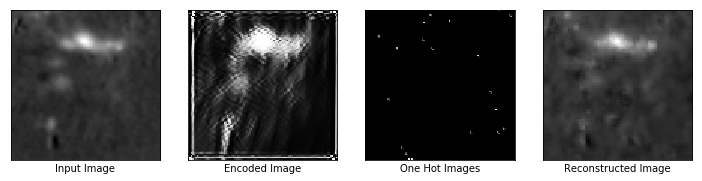

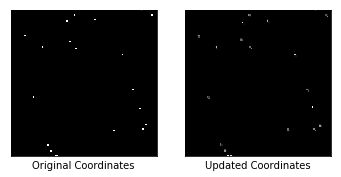

Epochs: 1520, Loss: 0.0023063465487211943
Similarity scores: [0.6387144  0.02057048 0.706007   0.13356195 0.05233498 0.07134284
 0.02565014 0.00321013 0.06387456 0.02280392 0.04205581 0.03149205
 0.02944948 0.0403018  0.11496554 0.13427223 0.21357717 0.00156229
 0.91071916 0.03229855]
Updated Coordinates: [[[0.24623339 0.9263295 ]]]
Gradient min:-0.0028233241755515337, max:0.003578022588044405



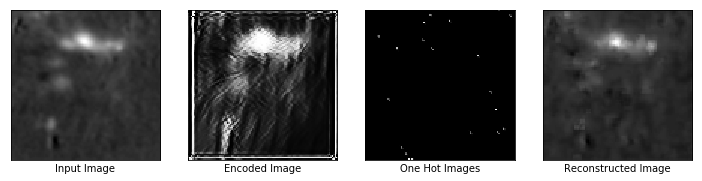

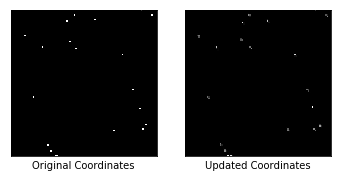

Epochs: 1530, Loss: 0.001511982292868197
Similarity scores: [0.6308563  0.0328219  0.7281452  0.15474626 0.07839947 0.11253716
 0.02924898 0.00854406 0.06845722 0.0259726  0.05642229 0.02583492
 0.04479456 0.08343217 0.10346807 0.15640984 0.2041924  0.00784871
 0.9171091  0.06529798]
Updated Coordinates: [[[0.24618992 0.9261966 ]]]
Gradient min:-0.0006128770764917135, max:0.0010676898527890444



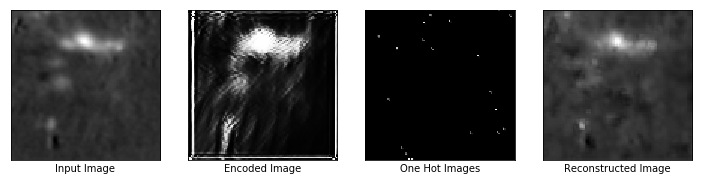

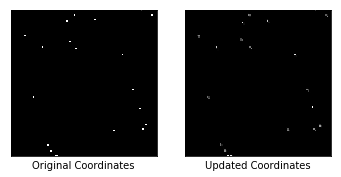

Epochs: 1540, Loss: 0.0019476047018542886
Similarity scores: [0.59706366 0.01247227 0.67515916 0.09897975 0.03149555 0.07193626
 0.01710552 0.00339871 0.02630502 0.00933782 0.02431819 0.02328391
 0.020033   0.02261514 0.04964625 0.07435337 0.17040528 0.00341152
 0.94589233 0.02406549]
Updated Coordinates: [[[0.24613442 0.9262996 ]]]
Gradient min:-0.00038820141344331205, max:0.0010093535529449582



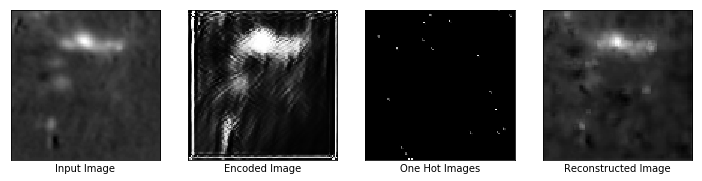

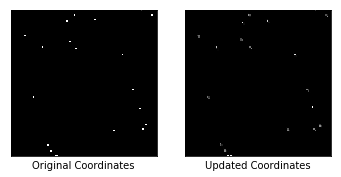

Epochs: 1550, Loss: 0.001764067099429667
Similarity scores: [0.5453454  0.01889797 0.7730232  0.08665449 0.05134841 0.0759655
 0.02624273 0.00121588 0.03641763 0.01582904 0.03890559 0.0216853
 0.02658778 0.03981135 0.09109072 0.11974458 0.13242508 0.00328982
 0.9351543  0.04030379]
Updated Coordinates: [[[0.24625988 0.9262124 ]]]
Gradient min:-0.0003496009740047157, max:0.0012546097859740257



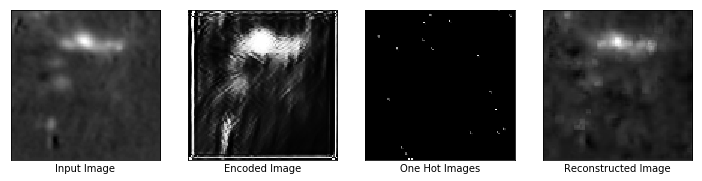

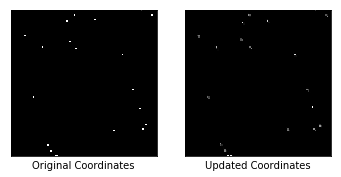

Epochs: 1560, Loss: 0.0016708564944565296
Similarity scores: [0.58726895 0.02097444 0.7511673  0.09581754 0.05030754 0.08089668
 0.01251047 0.0034155  0.03552045 0.01819498 0.04234152 0.02649019
 0.02872927 0.04017128 0.08896194 0.14278513 0.10589189 0.01642979
 0.96974814 0.0417851 ]
Updated Coordinates: [[[0.24636093 0.9261185 ]]]
Gradient min:-0.0005936977104283869, max:0.0009425625903531909



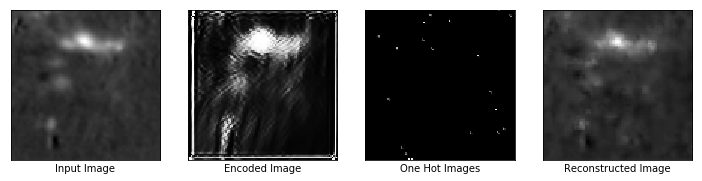

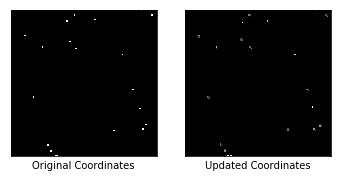

Epochs: 1570, Loss: 0.001543679041787982
Similarity scores: [0.60312504 0.02175366 0.70441806 0.11567029 0.04687965 0.07567547
 0.01995812 0.0053442  0.03355338 0.01634795 0.04074349 0.03281467
 0.02900436 0.03868352 0.05743008 0.12089776 0.25322866 0.02107265
 0.9423237  0.0241973 ]
Updated Coordinates: [[[0.24626267 0.9263948 ]]]
Gradient min:-0.0007626997539773583, max:0.0007860315963625908


In [ ]:
BATCH_SIZE = 8
MAX_EPOCHS = 2000
batch_imgs= tf.data.Dataset.from_tensor_slices(re_list).batch(BATCH_SIZE, drop_remainder=True)

#list to be append to output 
loss_list = []
input_imgs = []
coords_list = []
encoded_imgs = []
reconstructed_imgs = []
one_hot_imgs_list = []
similarity_list = []

captions_01 = ['Input Image', 'Encoded Image', 'One Hot Images','Reconstructed Image']
captions_02 = ['Original Coordinates', 'Updated Coordinates']

epochs = 1
while epochs <= MAX_EPOCHS:
    #reset coords for each epochs
#     coords,_, ori_one_hot_imgs = create_dat_samples(n_neurons)
#     coords = tf.reshape(coords, [n_neurons, 1,1,2])
    for steps, batched_imgs in enumerate(batch_imgs):
        loss, updated_coords, one_hot_imgs, encoder_output, similarity_score, reconstruction, grad_model  = train_fn(batched_imgs, coords, img_size, BATCH_SIZE)
    #loss is append for each epochs
    loss_list.append(loss)
    if epochs%10==0:
        img_row01 = [batched_imgs[0], encoder_output[0], stack4plot(one_hot_imgs), reconstruction[0]]
        img_row02 = [stack4plot(ori_one_hot_imgs), stack4plot(one_hot_imgs)]
        plot_comparison(img_row01, captions_01, n_col=len(img_row01), figsize = (10, 10))
        plot_comparison(img_row02, captions_02, n_col=len(img_row02))
        print("Epochs: {}, Loss: {}".format(epochs, loss.numpy()))
        print("Similarity scores: {}".format(similarity_score[0]))
        print("Updated Coordinates: {}".format(updated_coords[0]))
        print("Gradient min:{}, max:{}".format(np.min(grad_model[0]), np.max(grad_model[0])))
    #append list for every 100 epochs 
    if epochs%100==0:
        encoded_imgs.append(encoder_output)
        input_imgs.append(batched_imgs)
        coords_list.append(updated_coords)
        reconstructed_imgs.append(reconstruction)
        one_hot_imgs_list.append(one_hot_imgs)
        similarity_list.append(similarity_score)
        
    epochs+=1

----

# Save Output Data

In [33]:
# save_list = [loss_list, input_imgs, coords_list, encoded_imgs, reconstructed_imgs, one_hot_imgs_list, similarity_list]
# save_names = ['loss_list', 'input_imgs', 'coords_list', 'encoded_imgs', 'reconstructed_imgs', 'one_hot_imgs_list', 'similarity_list']

# for names, items in zip(save_names, save_list):
#     tensor = tf.convert_to_tensor(items, tf.float32)
#     np.save('npy/{}_full03.npy'.format(names), np.array(tensor))
    

In [51]:
# #save coords amd one hot images()
# np.save('npy/{}_full03.npy'.format('ori_coords'), np.array(coords))
# np.save('npy/{}_full03.npy'.format('ori_one_hot_imgs'), np.array(ori_one_hot_imgs))

---

# Visualization

In [3]:
coords_list_npy = np.load('npy/{}_full04.npy'.format('coords_list')) 
encoded_imgs_npy = np.load('npy/{}_full04.npy'.format('encoded_imgs'))
input_imgs_npy = np.load('npy/{}_full04.npy'.format('input_imgs'))
loss_list_npy = np.load('npy/{}_full04.npy'.format('loss_list'))
one_hot_imgs_list_npy = np.load('npy/{}_full04.npy'.format('one_hot_imgs_list'))
reconstructed_imgs_npy = np.load('npy/{}_full04.npy'.format('reconstructed_imgs'))
similarity_list_npy = np.load('npy/{}_full04.npy'.format('similarity_list'))
ori_coords_npy = np.load('npy/{}_full04.npy'.format('ori_coords'))
ori_one_hot_imgs_npy = np.load('npy/{}_full04.npy'.format('ori_one_hot_imgs'))

In [4]:
#load roi mask
roi_img = np.load('/home/kevinteng/Desktop/Manual_annotation/DG-13-3-8-17_ROImask.npy')
roi_img = cv2.resize(roi_img, (100, 100))
# plt.imshow(roi_img, cmap = 'gray')

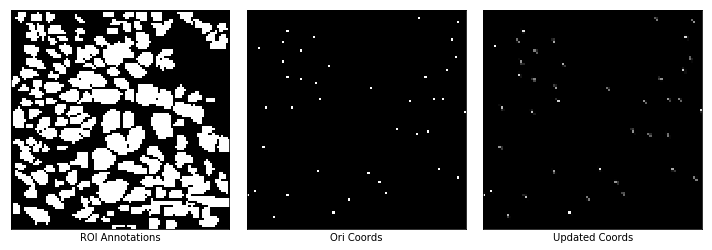

In [7]:
#comparison of roi and one hot images 
captions_03 = ['ROI Annotations', 'Ori Coords', 'Updated Coords']
img_row03 = [roi_img, stack4plot(ori_one_hot_imgs_npy), stack4plot(one_hot_imgs_list_npy[-1])]
plot_comparison(img_row03, captions_03, n_col=len(img_row03), figsize = (10, 10))

In [ ]:
#checking coords of highest and lowest similarity score

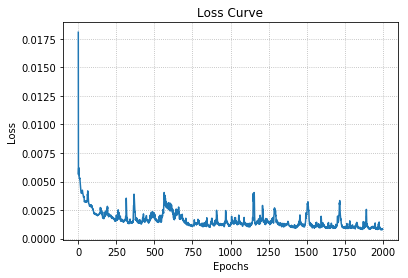

In [5]:
#plot loss
xlabel = 'Epochs'
ylabel = 'Loss'
title = 'Loss Curve'
utils_vis.plot_loss(loss_list_npy, xlabel, ylabel, title)